# EG25 CITE-seq and flow cytometry comparisons

In this notebook 2-component Gaussian mixture model (GMM) is used to separate background signal from true signal. For some of the Easigenomics samples, blast phenotype data from flow cytometry is available, here this flow data is compared to CITE-seq results. Model is applied for both CLR and DSB normalized protein counts. 

Only one sample (leukemic cells/balsts selected) is used to train the model, then the surface protein status of blasts is predicted. 


### Sample information:
- ALL
- diagnosis
- 93% of bone marrow cells are blasts

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
import scvi
import scanpy as sc
from ridgeplot import ridgeplot

import sklearn.mixture

import warnings

warnings.filterwarnings('ignore')

## Preparing files

In [3]:
#raw protein data, all datasets, raw + CLR and DSB normalized

adata = sc.read_h5ad('/Users/tiinatuononen/Desktop/Thesis/Project/data/adata_easi_norm.h5ad')

adata.shape

(121340, 8051)

In [4]:
#select sample
adata_sample=adata[adata.obs['eg_code'] == 'EG25']

In [5]:
#selecting only leukemic cells

eg_blasts=adata_sample[adata_sample.obs['new_cell_type'] == 'leukemic']

eg_blasts.obs['new_cell_type']

AAACCTGCATCTGGTA-1-158    leukemic
AAACCTGGTATGAAAC-1-158    leukemic
AAACCTGGTCGAACAG-1-158    leukemic
AAACCTGGTCTGCGGT-1-158    leukemic
AAACCTGTCAGCTCGG-1-158    leukemic
                            ...   
TTTGTCACATCGGGTC-1-158    leukemic
TTTGTCAGTACATCCA-1-158    leukemic
TTTGTCAGTAGGCATG-1-158    leukemic
TTTGTCAGTATGCTTG-1-158    leukemic
TTTGTCATCAAACCAC-1-158    leukemic
Name: new_cell_type, Length: 2843, dtype: category
Categories (1, object): ['leukemic']

In [6]:
#select CLR normalized protein counts (only leukemic cells)

prot_clr=eg_blasts.obsm['protein_expression_clr']

prot_clr

,CD19,CD10,CD20,CD3,CD2,CD11b,HLADR,CD38,CD11c,CD7,...,CD5,CD15,CD64,CD117,CD24,CD44,CD58,CD66ace,CD13,CD34
AAACCTGCATCTGGTA-1-158,0.839867,4.407963,0.686648,0.803706,0.454747,0.941108,2.176352,0.454747,0.554048,0.401137,...,0.401137,0.727209,0.454747,0.344489,0.152298,1.417221,0.284438,0.284438,0.000000,2.047021
AAACCTGGTATGAAAC-1-158,1.331921,5.233720,0.685171,0.552783,0.598887,0.725672,2.145328,0.873031,0.400154,0.283702,...,0.283702,0.219961,0.283702,0.642959,0.453661,2.012062,0.725672,0.453661,0.078820,2.504322
AAACCTGGTCGAACAG-1-158,1.166579,4.043257,0.977665,0.828440,0.652974,0.440026,1.462441,0.169109,0.313714,0.169109,...,0.313714,1.044681,1.166579,0.169109,0.000000,2.442538,0.552157,0.000000,0.000000,2.359056
AAACCTGGTCTGCGGT-1-158,1.156437,4.337609,0.347108,0.659425,0.417862,0.897064,2.535214,0.545920,0.604282,0.098706,...,0.188539,0.417862,0.000000,0.417862,0.188539,2.644153,0.938496,0.761350,0.270963,2.575497
AAACCTGTCAGCTCGG-1-158,1.480234,4.813234,0.562022,0.465367,0.621631,0.465367,2.523716,0.677885,0.358360,0.195148,...,0.430955,0.430955,0.395316,0.102327,0.395316,2.774490,0.280080,0.621631,0.238515,2.614476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCACATCGGGTC-1-158,1.113359,4.580938,0.929573,0.186029,0.478326,0.412866,2.352065,0.800539,0.342819,0.267494,...,0.342819,0.597642,0.478326,0.097334,0.412866,1.146385,0.539762,0.597642,0.000000,2.034032
TTTGTCAGTACATCCA-1-158,0.945062,4.592076,0.799048,0.580251,0.530098,0.910508,1.262496,0.945062,0.299771,0.421551,...,0.299771,0.421551,0.421551,0.530098,0.978461,1.262496,0.628008,0.628008,0.421551,1.559755
TTTGTCAGTAGGCATG-1-158,0.812841,4.175203,0.607699,0.951188,0.775042,0.652233,1.100905,0.775042,0.406612,0.154642,...,0.288542,0.652233,0.349319,0.154642,0.080307,1.578263,0.607699,0.694867,0.460800,1.794624
TTTGTCAGTATGCTTG-1-158,1.152217,4.674524,0.669208,0.359799,0.526422,0.669208,1.205498,0.669208,0.159749,0.297459,...,0.473907,0.712605,0.418479,0.359799,0.230972,1.865058,0.418479,0.297459,0.230972,2.002696


In [7]:
#select DSB normalized protein counts

prot_dsb=eg_blasts.obsm['protein_expression_dsb']

prot_dsb

,CD19,CD10,CD20,CD3,CD2,CD11b,HLADR,CD38,CD11c,CD7,...,CD5,CD15,CD64,CD117,CD24,CD44,CD58,CD66ace,CD13,CD34
AAACCTGCATCTGGTA-1-158,1.233499,10.490325,0.298399,0.481133,0.447542,2.209640,10.253304,3.167907,1.722448,2.455797,...,0.891578,1.301091,0.046385,0.448538,-0.182913,4.108888,-0.730510,0.174821,-1.242754,8.957834
AAACCTGGTATGAAAC-1-158,3.047345,13.421921,0.298399,-0.124804,1.439466,1.098438,10.084808,7.173814,0.597070,1.329014,...,-0.012207,-1.804461,-0.560621,2.406809,2.581179,6.888614,1.705478,1.484647,-0.329018,11.624531
AAACCTGGTCGAACAG-1-158,0.657536,6.412783,-0.169555,-0.370382,-0.316384,-1.636618,2.570349,-0.601559,-1.286844,-0.705994,...,-1.055551,0.540348,0.852458,-1.356567,-1.629780,5.610284,-0.730510,-2.095107,-1.242754,6.712157
AAACCTGGTCTGCGGT-1-158,1.839929,9.431325,-1.144322,-0.124804,-0.316384,1.302459,11.125561,3.167907,1.368383,-0.705994,...,-1.055551,-1.025544,-1.612562,0.448538,-0.182913,8.797567,2.114627,2.910192,1.272525,10.792358
AAACCTGTCAGCTCGG-1-158,4.792845,13.411078,0.576136,0.096173,3.040791,0.662341,14.631488,7.488725,1.368383,1.329014,...,2.401888,0.540348,0.394119,-0.850160,3.463843,12.191087,-0.075279,4.351017,2.644428,14.531251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCACATCGGGTC-1-158,1.726878,10.341841,0.706438,-1.139418,0.077523,-0.950627,10.141519,5.400477,-0.277374,0.703665,...,-0.012207,-0.033143,-0.143150,-1.356567,1.587909,2.140529,0.222203,1.870252,-1.242754,7.795315
TTTGTCAGTACATCCA-1-158,1.489006,10.929936,0.576136,-0.124804,0.796405,1.867083,4.496425,7.488725,-0.277374,2.455797,...,-0.012207,-0.674252,-0.143150,1.509651,6.819550,3.174085,1.019674,2.581041,3.263157,5.819686
TTTGTCAGTAGGCATG-1-158,1.098276,9.608678,-0.005828,0.808834,2.552255,0.662341,3.698918,6.153918,0.597070,0.028237,...,-0.012207,0.805919,-0.344923,-0.850160,-0.873417,4.802882,1.019674,3.224028,3.844364,7.402730
TTTGTCAGTATGCTTG-1-158,2.258353,11.252911,0.149908,-0.646733,0.796405,0.662341,4.190423,4.997655,-1.286844,1.329014,...,1.301905,1.059134,-0.143150,0.448538,0.452290,5.996411,-0.075279,0.174821,1.272525,8.440183


In [8]:
#convert excel to csv (flow data)

read_file = pd.read_excel (r'/Users/tiinatuononen/Desktop/Thesis/Project/data/flow.xlsx')
read_file.to_csv (r'/Users/tiinatuononen/Desktop/Thesis/Project/data/flow.csv', index = None, header=True)

In [9]:
#get flow data

flow= pd.read_csv('/Users/tiinatuononen/Desktop/Thesis/Project/data/flow.csv')

### Depending on used dataset, celltype annotations are varying (made by different groups). "new_cell_types" is made based on these, it is a "standardized" version of cell type annotations. 

In [10]:
#Cell types offered by new_cell_type

adata.obs['new_cell_type'].unique().tolist()

['NK',
 'non-leukemic',
 'preleukemic',
 'non-leukemic?',
 nan,
 'leukemic',
 'leukemic?',
 'doublets?',
 'unknown',
 '0',
 'preleukemic?']

In [11]:
#cell type annotations offered by cell_type

adata.obs['cell_type'].unique().tolist()

['NKT',
 'non-leukemic',
 'preleukemic',
 'non-leukemic?',
 nan,
 'leukemic',
 'leukemic?',
 'doublets?',
 'unknown',
 '0',
 'preleukemic?']

## CLR normalized



In [12]:
#CLR normalized, only leukemic cells

prot_clr

,CD19,CD10,CD20,CD3,CD2,CD11b,HLADR,CD38,CD11c,CD7,...,CD5,CD15,CD64,CD117,CD24,CD44,CD58,CD66ace,CD13,CD34
AAACCTGCATCTGGTA-1-158,0.839867,4.407963,0.686648,0.803706,0.454747,0.941108,2.176352,0.454747,0.554048,0.401137,...,0.401137,0.727209,0.454747,0.344489,0.152298,1.417221,0.284438,0.284438,0.000000,2.047021
AAACCTGGTATGAAAC-1-158,1.331921,5.233720,0.685171,0.552783,0.598887,0.725672,2.145328,0.873031,0.400154,0.283702,...,0.283702,0.219961,0.283702,0.642959,0.453661,2.012062,0.725672,0.453661,0.078820,2.504322
AAACCTGGTCGAACAG-1-158,1.166579,4.043257,0.977665,0.828440,0.652974,0.440026,1.462441,0.169109,0.313714,0.169109,...,0.313714,1.044681,1.166579,0.169109,0.000000,2.442538,0.552157,0.000000,0.000000,2.359056
AAACCTGGTCTGCGGT-1-158,1.156437,4.337609,0.347108,0.659425,0.417862,0.897064,2.535214,0.545920,0.604282,0.098706,...,0.188539,0.417862,0.000000,0.417862,0.188539,2.644153,0.938496,0.761350,0.270963,2.575497
AAACCTGTCAGCTCGG-1-158,1.480234,4.813234,0.562022,0.465367,0.621631,0.465367,2.523716,0.677885,0.358360,0.195148,...,0.430955,0.430955,0.395316,0.102327,0.395316,2.774490,0.280080,0.621631,0.238515,2.614476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCACATCGGGTC-1-158,1.113359,4.580938,0.929573,0.186029,0.478326,0.412866,2.352065,0.800539,0.342819,0.267494,...,0.342819,0.597642,0.478326,0.097334,0.412866,1.146385,0.539762,0.597642,0.000000,2.034032
TTTGTCAGTACATCCA-1-158,0.945062,4.592076,0.799048,0.580251,0.530098,0.910508,1.262496,0.945062,0.299771,0.421551,...,0.299771,0.421551,0.421551,0.530098,0.978461,1.262496,0.628008,0.628008,0.421551,1.559755
TTTGTCAGTAGGCATG-1-158,0.812841,4.175203,0.607699,0.951188,0.775042,0.652233,1.100905,0.775042,0.406612,0.154642,...,0.288542,0.652233,0.349319,0.154642,0.080307,1.578263,0.607699,0.694867,0.460800,1.794624
TTTGTCAGTATGCTTG-1-158,1.152217,4.674524,0.669208,0.359799,0.526422,0.669208,1.205498,0.669208,0.159749,0.297459,...,0.473907,0.712605,0.418479,0.359799,0.230972,1.865058,0.418479,0.297459,0.230972,2.002696


In [13]:
#flow results for selected sample

egflow=flow[flow['EG_code'] == 'EG24'].dropna(axis=1)

egflow

,EG_code,CD10,CD19,CD22,CD34,CD38,CD58,CD66c,CD133,HLA-DR
1,EG24,1.0,1.0,1.0,0.68,1.0,1.0,0.45,0.51,1.0


In [14]:
#drop EG_code

egflow=egflow.drop("EG_code", axis=1)

egflow

,CD10,CD19,CD22,CD34,CD38,CD58,CD66c,CD133,HLA-DR
1,1.0,1.0,1.0,0.68,1.0,1.0,0.45,0.51,1.0


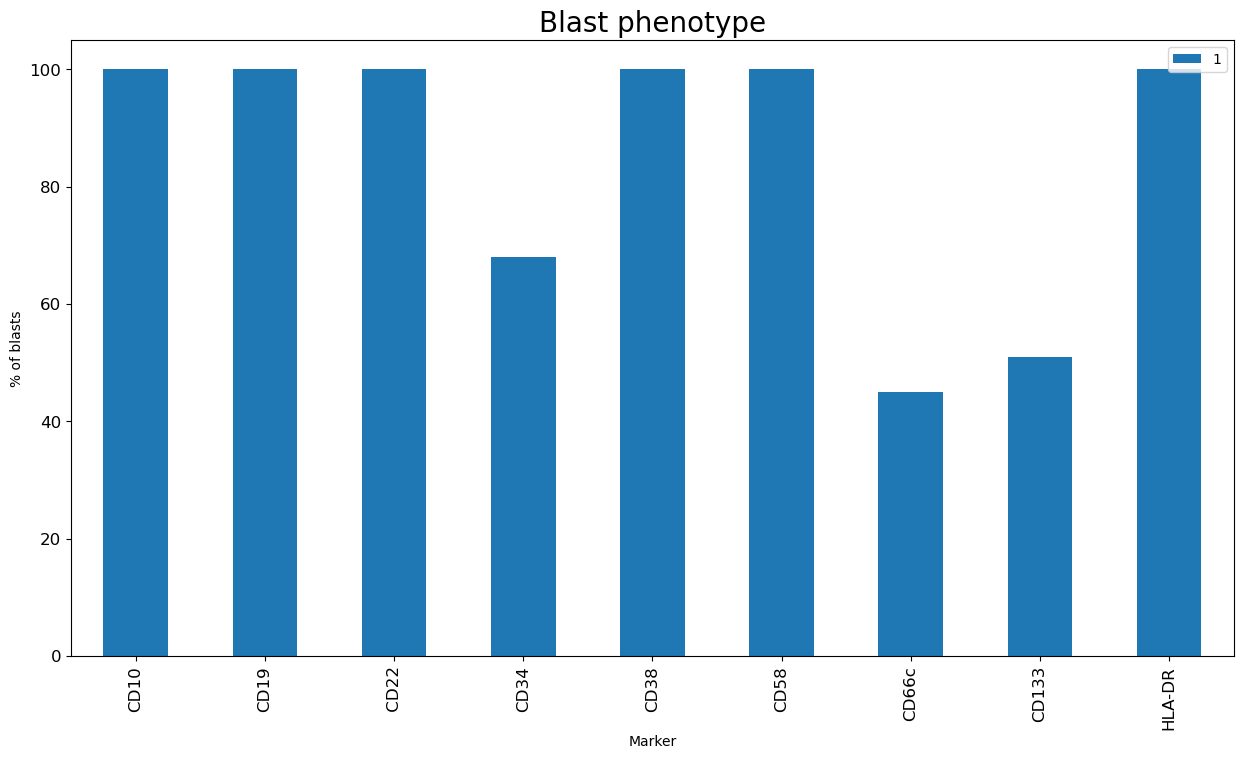

In [15]:
df=egflow * 100 #multiplied by 100 to get percentages

df1=df.T

df1.plot.bar(xlabel="Marker", ylabel="% of blasts",
            figsize= (15,8),
           fontsize="large") ;

plt.title('Blast phenotype', fontsize=20) ;

In [16]:
egflow=egflow*100

In [17]:
flow_markers=egflow.columns
flow_markers

Index(['CD10', 'CD19', ' CD22', 'CD34', 'CD38', 'CD58', 'CD66c', 'CD133',
       'HLA-DR'],
      dtype='object')

In [18]:
#Selecting common markers between flow and cite-seq

listOfMarkers=flow_markers
column_names=list()    #list including the common markers

for x in listOfMarkers:
    if x in prot_clr.columns:
        print(x, "Yes")
        column_names.append(x)
    else:
        print(x, "No") 
        
print(column_names)

CD10 Yes
CD19 Yes
 CD22 No
CD34 Yes
CD38 Yes
CD58 Yes
CD66c No
CD133 No
HLA-DR No
['CD10', 'CD19', 'CD34', 'CD38', 'CD58']


In [19]:
prot_clr.shape

(2843, 33)

In [20]:
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

Silhuette score: 0.5551240240755948
Percentage of positive cells, based on GMM: 71.86071051705945


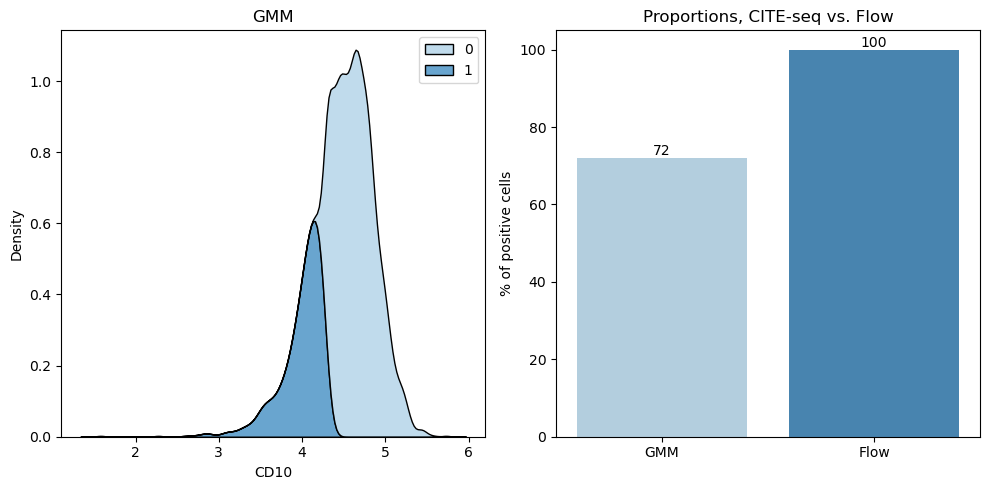

Silhuette score: 0.8092188376892971
Percentage of positive cells, based on GMM: 0.6683081252198383


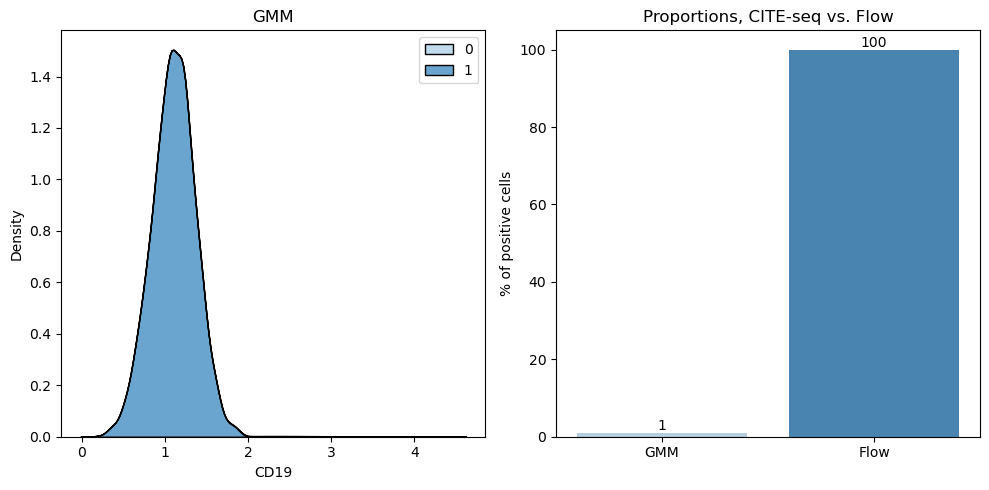

Silhuette score: 0.5545293036695828
Percentage of positive cells, based on GMM: 55.715793176222306


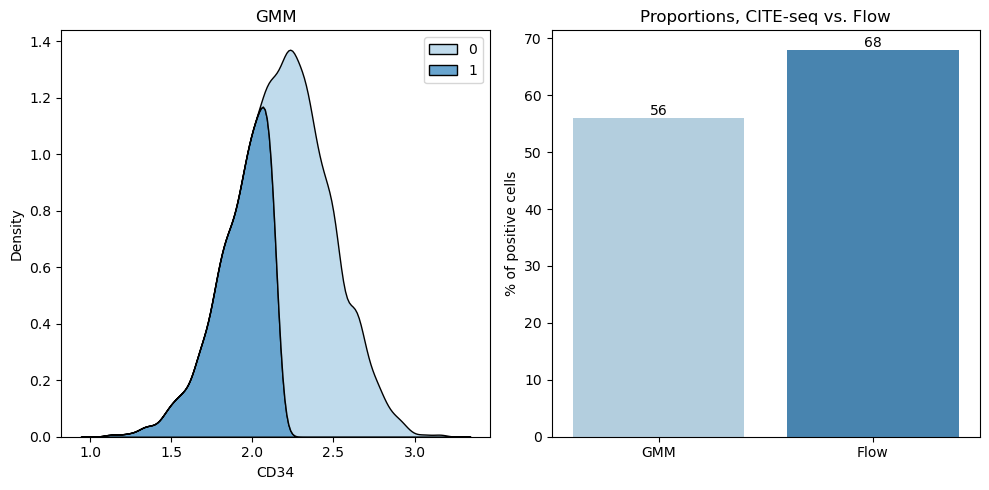

Silhuette score: 0.5699960271594212
Percentage of positive cells, based on GMM: 34.365107281041155


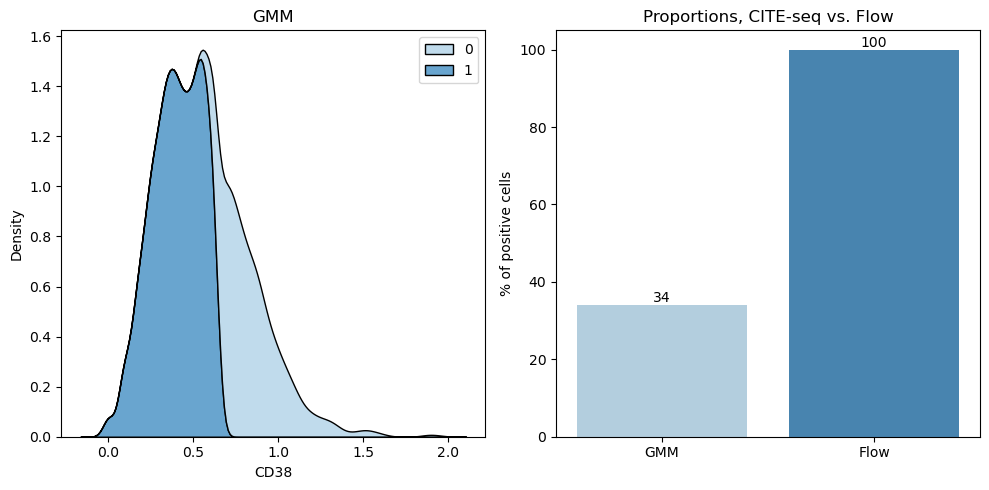

Silhuette score: 0.5353859459496865
Percentage of positive cells, based on GMM: 18.360886387618713


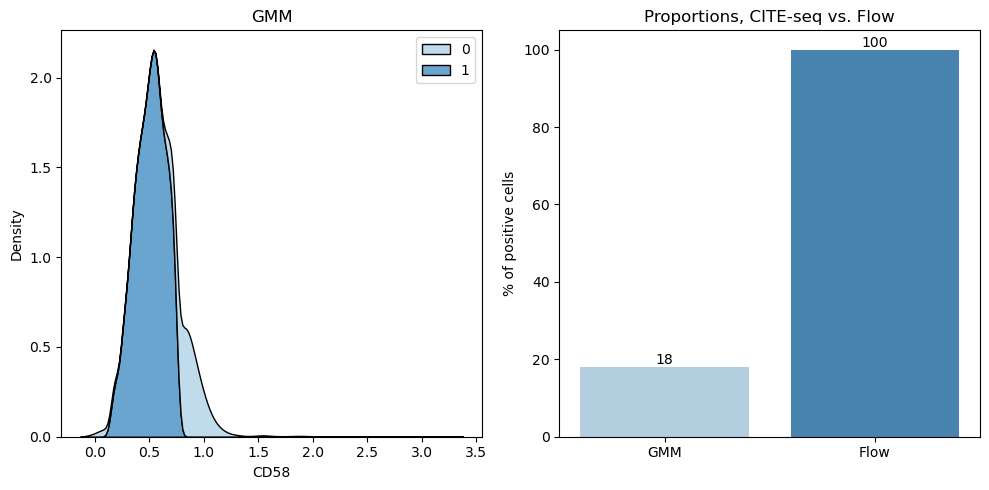

In [21]:
#model
gmm = sklearn.mixture.GaussianMixture(n_components = 2,
                                      covariance_type = "diag",
                                      random_state = 42
                                        )
#data
data=prot_clr
n_cells=len(prot_clr)
egflow=egflow
silhuette_scores_clr_diag = []

for column_name in column_names:
    fig, ax =plt.subplots(1,2,tight_layout=True, figsize=(10, 5))
    fig.show()
    
    x= data[column_name]
    x=x.values.reshape(-1, 1)
    gmm.fit(x)
    labels = gmm.predict(x)
    score = silhouette_score(x, labels)
    print("Silhuette score:", score)
    silhuette_scores_clr_diag.append(score)
    
    x0 = data[column_name].reset_index(drop=True)[labels == 0].mean()
    x1 = data[column_name].reset_index(drop=True)[labels == 1].mean()
    if x0 < x1:
        labels = (~(labels == 1)).astype(int)
    
    ax1 = sns.kdeplot(data=data, x=column_name, hue=labels, palette="Blues", multiple="stack", ax=ax[0]) ;
    ax1.title.set_text('GMM')
       
    #Calculate zeros
    n_zeros = np.count_nonzero(labels==0)
    result_zeros=(n_zeros/n_cells * 100)
    #Calculate ones
    n_ones=np.count_nonzero(labels)
    result_ones=(n_ones/n_cells * 100)
    #Dataframes
    all_data = {"GMM":[round(result_zeros)],
        "Flow": egflow[column_name],
        };

    all_data= pd.DataFrame(data=all_data);
    
    ax2=sns.barplot(data = all_data, palette = "Blues", ax=ax[1]);
    ax2.title.set_text('Proportions, CITE-seq vs. Flow')
    plt.ylabel("% of positive cells", fontsize=10);
    for container in ax2.containers:
        ax2.bar_label(container)
    
    print("Percentage of positive cells, based on GMM:", result_zeros)
    
    plt.show()

Silhuette score: 0.5551240240755948
Percentage of positive cells, based on GMM: 71.86071051705945


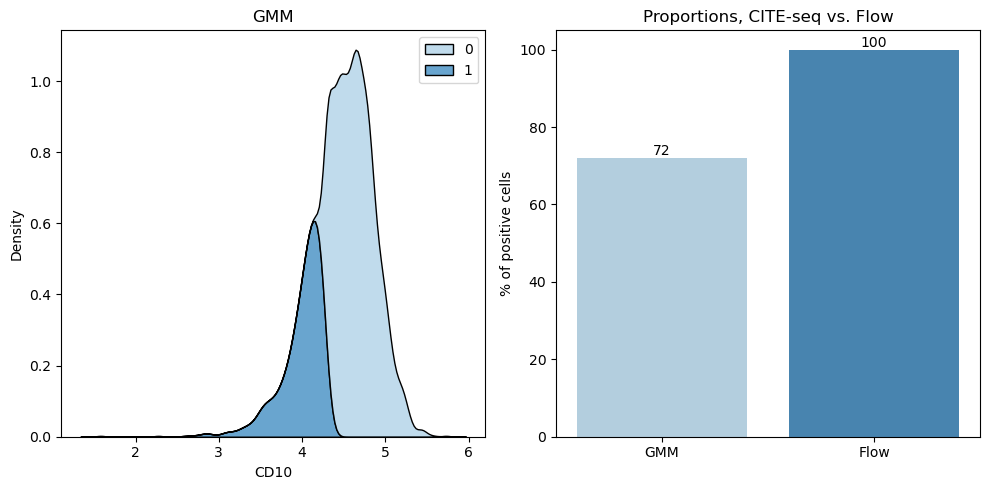

Silhuette score: 0.8092188376892971
Percentage of positive cells, based on GMM: 0.6683081252198383


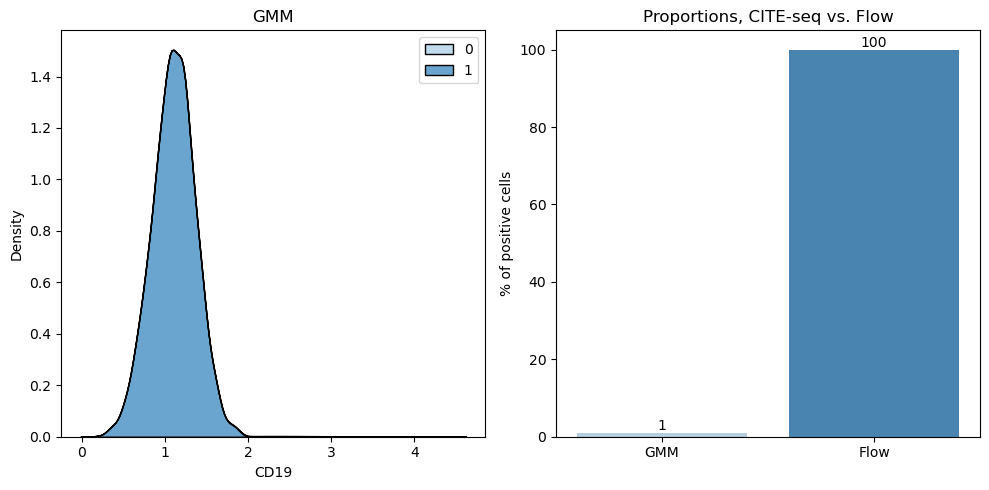

Silhuette score: 0.5545293036695828
Percentage of positive cells, based on GMM: 55.715793176222306


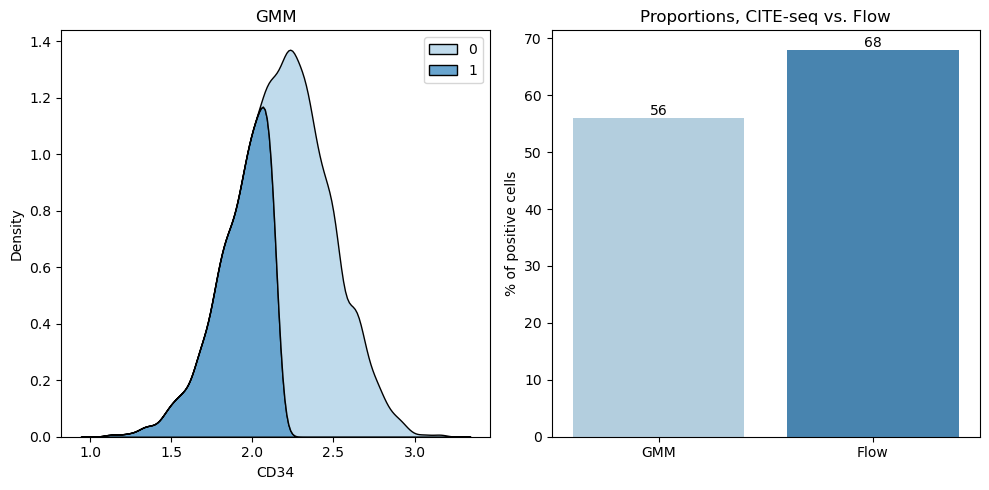

Silhuette score: 0.5699960271594212
Percentage of positive cells, based on GMM: 34.365107281041155


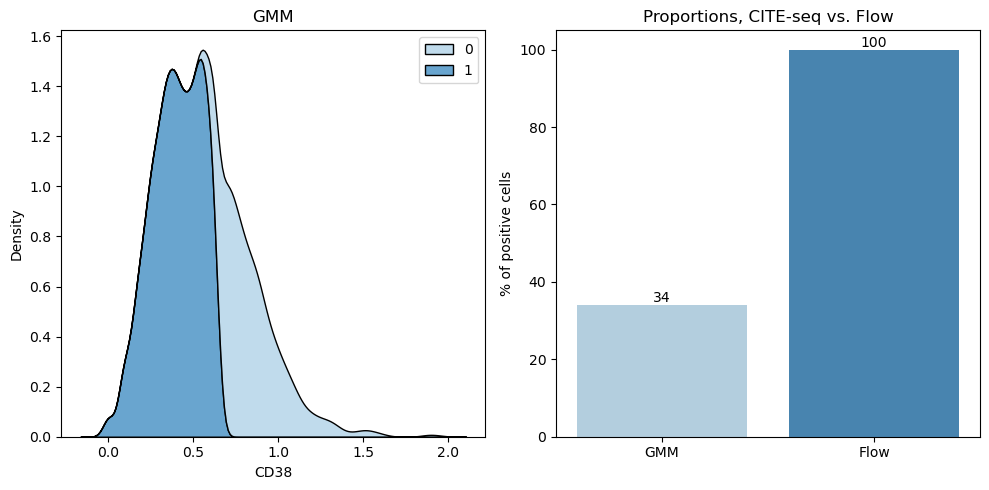

Silhuette score: 0.5353859459496865
Percentage of positive cells, based on GMM: 18.360886387618713


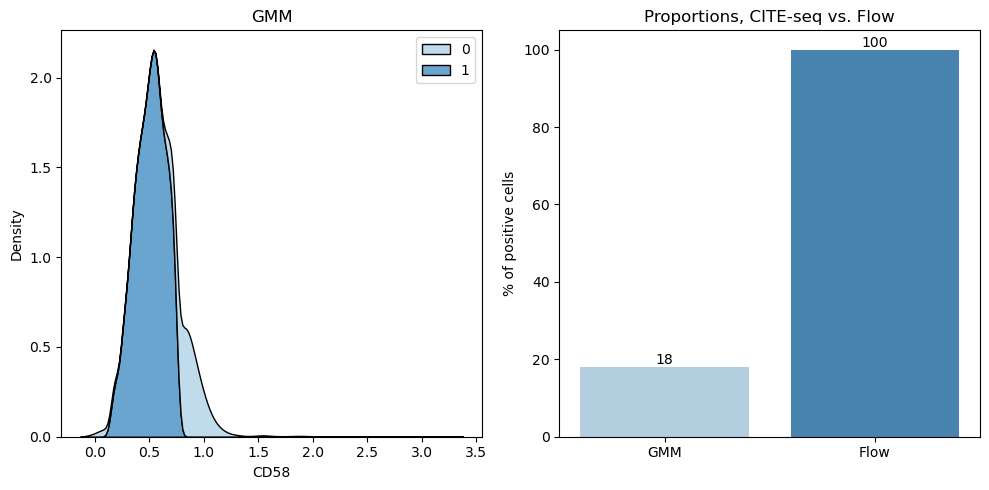

In [22]:
#model
gmm = sklearn.mixture.GaussianMixture(n_components = 2,
                                      covariance_type = "spherical",
                                      random_state = 42
                                        )
#data
data=prot_clr
n_cells=len(prot_clr)
egflow=egflow
silhuette_scores_clr_spher = []

for column_name in column_names:
    fig, ax =plt.subplots(1,2,tight_layout=True, figsize=(10, 5))
    fig.show()
    
    x= data[column_name]
    x=x.values.reshape(-1, 1)
    gmm.fit(x)
    labels = gmm.predict(x)
    score = silhouette_score(x, labels)
    print("Silhuette score:", score)
    silhuette_scores_clr_spher.append(score)
    
    x0 = data[column_name].reset_index(drop=True)[labels == 0].mean()
    x1 = data[column_name].reset_index(drop=True)[labels == 1].mean()
    if x0 < x1:
        labels = (~(labels == 1)).astype(int)
    
    ax1 = sns.kdeplot(data=data, x=column_name, hue=labels, palette="Blues", multiple="stack", ax=ax[0]) ;
    ax1.title.set_text('GMM')
       
    #Calculate zeros
    n_zeros = np.count_nonzero(labels==0)
    result_zeros=(n_zeros/n_cells * 100)
    #Calculate ones
    n_ones=np.count_nonzero(labels)
    result_ones=(n_ones/n_cells * 100)
    #Dataframes
    all_data = {"GMM":[round(result_zeros)],
        "Flow": egflow[column_name],
        };

    all_data= pd.DataFrame(data=all_data);
    
    ax2=sns.barplot(data = all_data, palette = "Blues", ax=ax[1]);
    ax2.title.set_text('Proportions, CITE-seq vs. Flow')
    plt.ylabel("% of positive cells", fontsize=10);
    for container in ax2.containers:
        ax2.bar_label(container)
    
    print("Percentage of positive cells, based on GMM:", result_zeros)
    
    plt.show()

Silhuette score: 0.539395258634148
Percentage of positive cells, based on GMM: 82.09637706647908


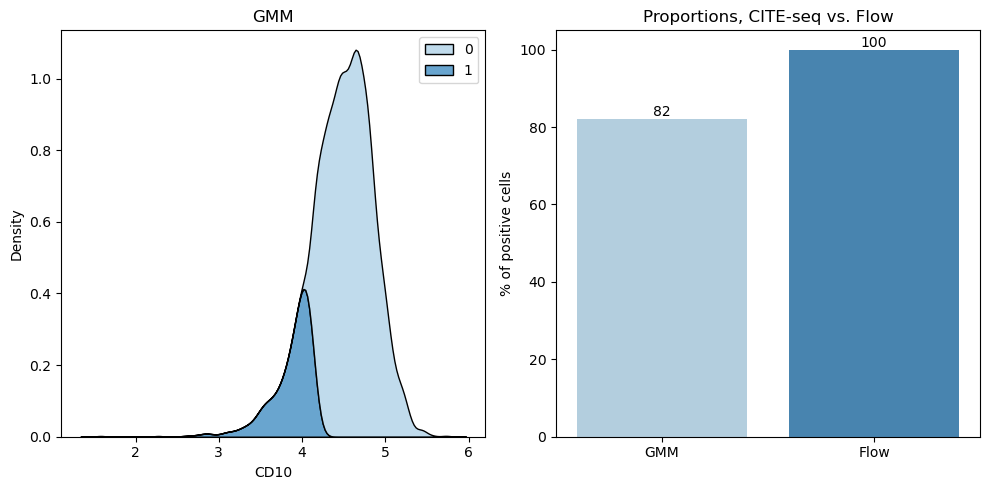

Silhuette score: 0.5004672840010135
Percentage of positive cells, based on GMM: 23.53148083010904


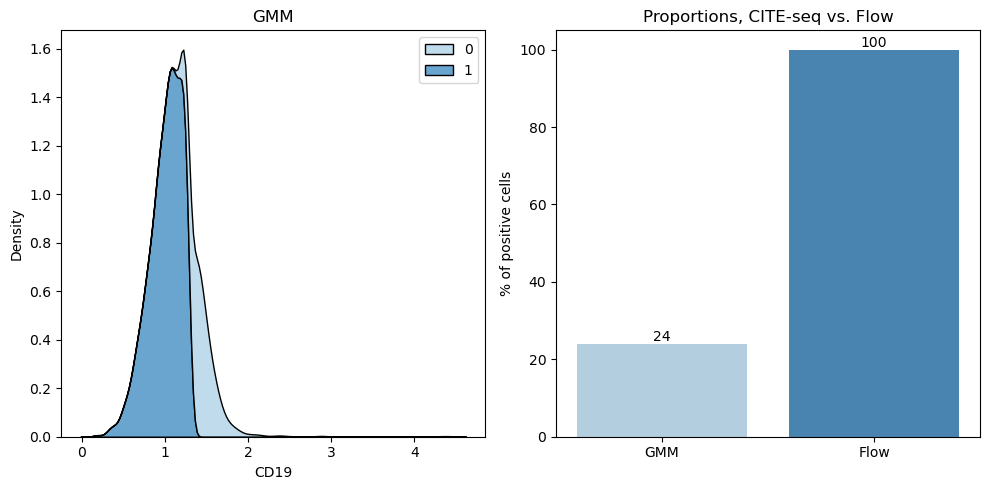

Silhuette score: 0.5531707167972383
Percentage of positive cells, based on GMM: 57.26345409778403


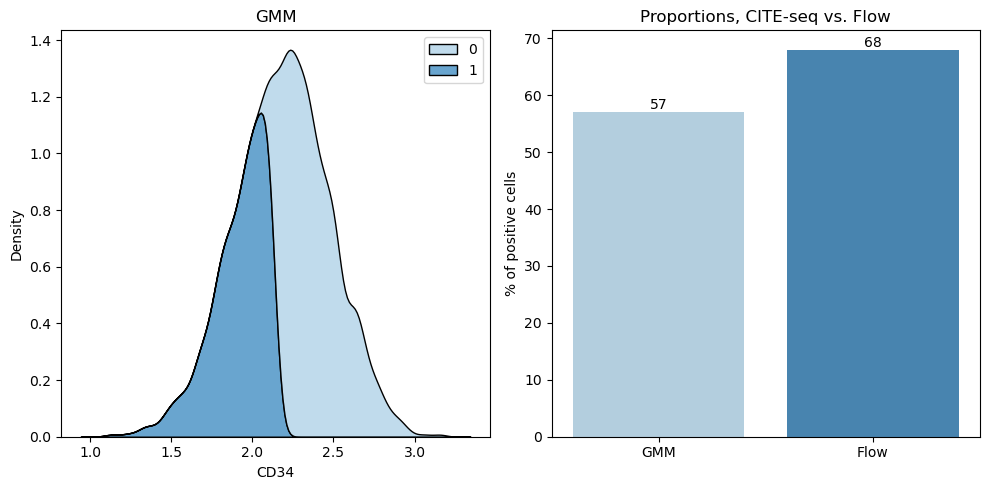

Silhuette score: 0.555971101742656
Percentage of positive cells, based on GMM: 20.82307421737601


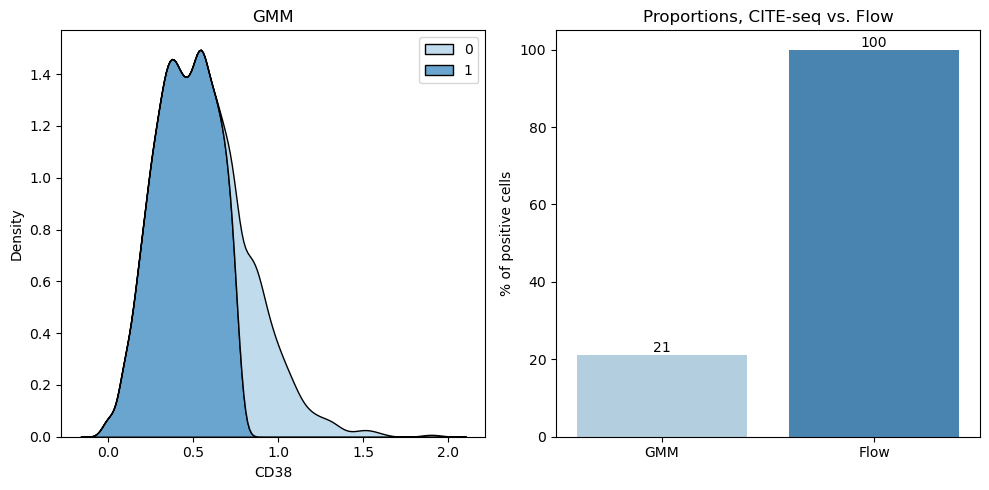

Silhuette score: 0.5417632265574519
Percentage of positive cells, based on GMM: 9.778403095321844


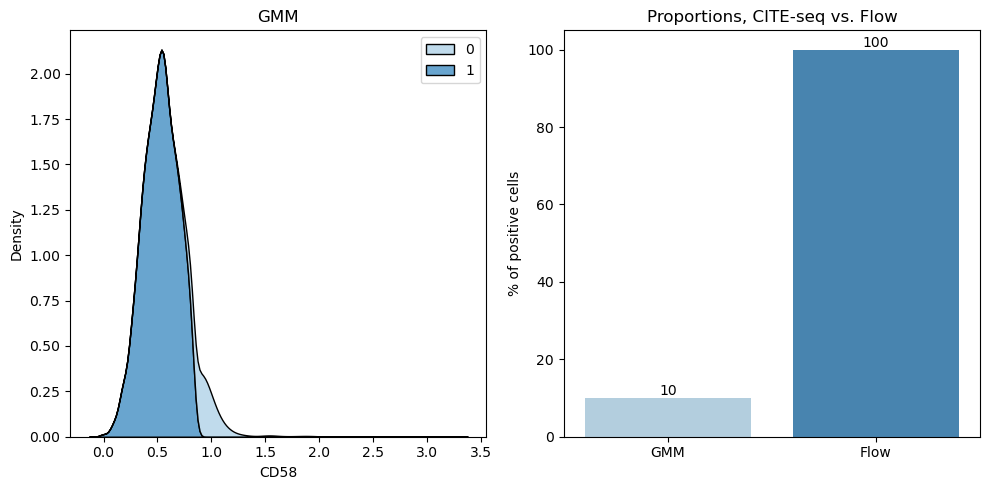

In [23]:
#model
gmm = sklearn.mixture.GaussianMixture(n_components = 2,
                                      covariance_type = "tied",
                                      random_state = 42
                                        )
#data

data=prot_clr
n_cells=len(prot_clr)
egflow=egflow
silhuette_scores_clr_tied = []


for column_name in column_names:
    fig, ax =plt.subplots(1,2,tight_layout=True, figsize=(10, 5))
    fig.show()
    
    x= data[column_name]
    x=x.values.reshape(-1, 1)
    gmm.fit(x)
    labels = gmm.predict(x)
    score = silhouette_score(x, labels)
    print("Silhuette score:", score)
    silhuette_scores_clr_tied.append(score)
    
    x0 = data[column_name].reset_index(drop=True)[labels == 0].mean()
    x1 = data[column_name].reset_index(drop=True)[labels == 1].mean()
    if x0 < x1:
        labels = (~(labels == 1)).astype(int)
    
    ax1 = sns.kdeplot(data=data, x=column_name, hue=labels, palette="Blues", multiple="stack", ax=ax[0]) ;
    ax1.title.set_text('GMM')
       
    #Calculate zeros
    n_zeros = np.count_nonzero(labels==0)
    result_zeros=(n_zeros/n_cells * 100)
    #Calculate ones
    n_ones=np.count_nonzero(labels)
    result_ones=(n_ones/n_cells * 100)
    #Dataframes
    all_data = {"GMM":[round(result_zeros)],
        "Flow": egflow[column_name],
        };

    all_data= pd.DataFrame(data=all_data);
    
    ax2=sns.barplot(data = all_data, palette = "Blues", ax=ax[1]);
    ax2.title.set_text('Proportions, CITE-seq vs. Flow')
    plt.ylabel("% of positive cells", fontsize=10);
    for container in ax2.containers:
        ax2.bar_label(container)
    
    print("Percentage of positive cells, based on GMM:", result_zeros)
    
    plt.show()

Silhuette score: 0.5551240240755948
Percentage of positive cells, based on GMM: 71.86071051705945


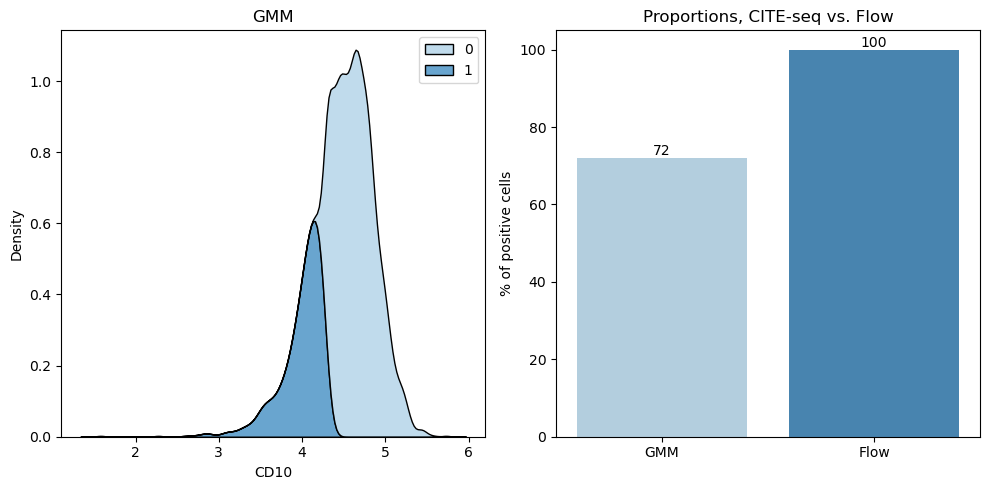

Silhuette score: 0.8092188376892971
Percentage of positive cells, based on GMM: 0.6683081252198383


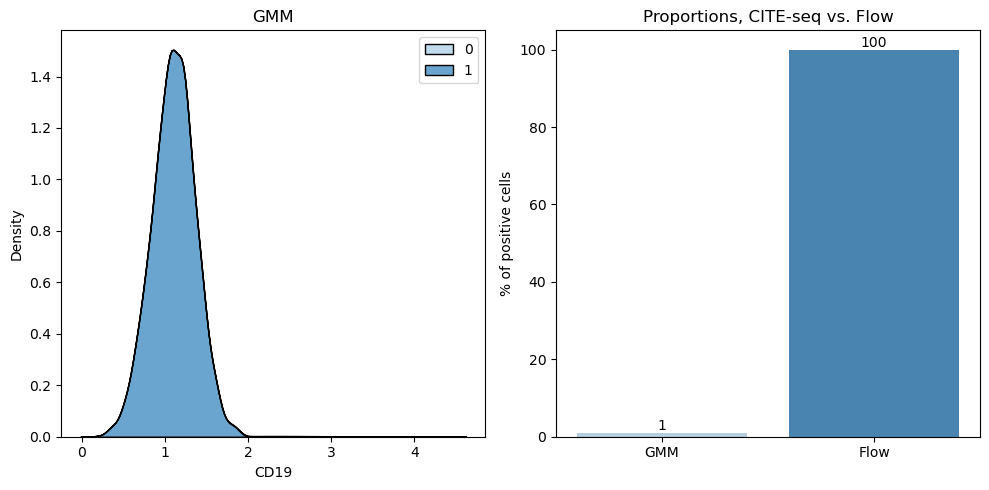

Silhuette score: 0.5545293036695828
Percentage of positive cells, based on GMM: 55.715793176222306


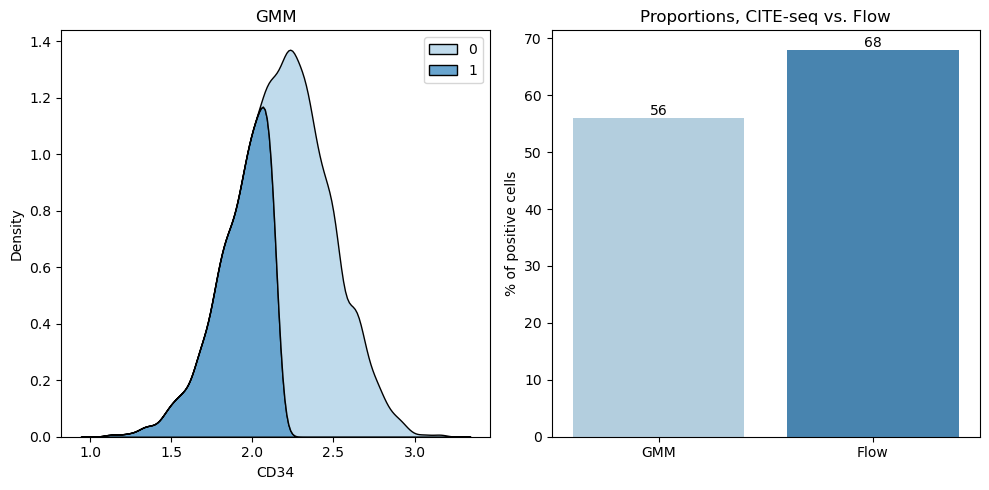

Silhuette score: 0.5699960271594212
Percentage of positive cells, based on GMM: 34.365107281041155


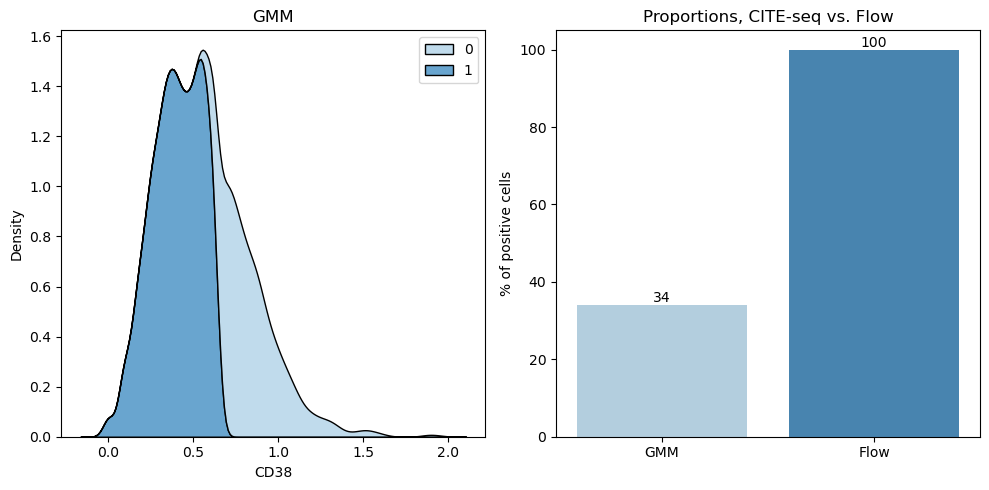

Silhuette score: 0.5353859459496865
Percentage of positive cells, based on GMM: 18.360886387618713


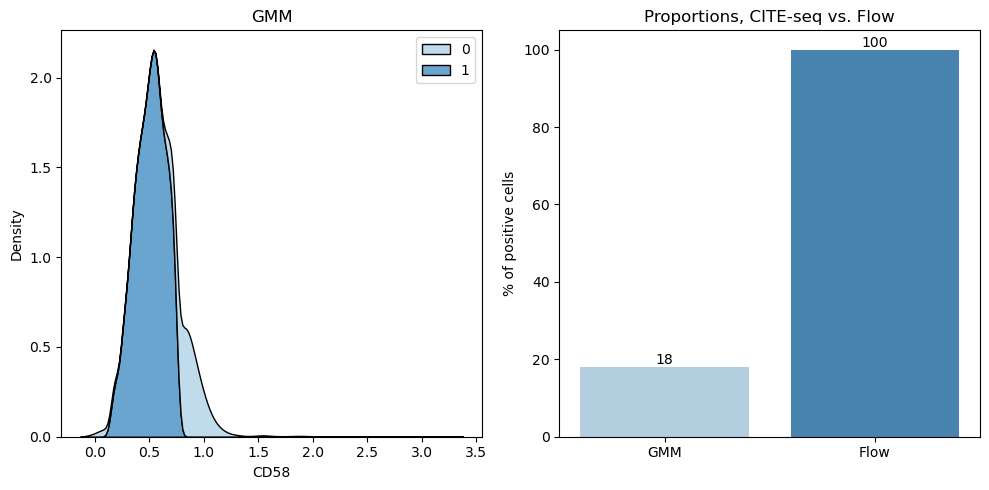

In [24]:
#model
gmm = sklearn.mixture.GaussianMixture(n_components = 2,
                                      covariance_type = "full",
                                      random_state = 42
                                        )
#data

data=prot_clr
n_cells=len(prot_clr)
egflow=egflow
silhuette_scores_clr_full = []

for column_name in column_names:
    fig, ax =plt.subplots(1,2,tight_layout=True, figsize=(10, 5))
    fig.show()
    
    x= data[column_name]
    x=x.values.reshape(-1, 1)
    gmm.fit(x)
    labels = gmm.predict(x)
    score = silhouette_score(x, labels)
    print("Silhuette score:", score)
    silhuette_scores_clr_full.append(score)
    
    x0 = data[column_name].reset_index(drop=True)[labels == 0].mean()
    x1 = data[column_name].reset_index(drop=True)[labels == 1].mean()
    if x0 < x1:
        labels = (~(labels == 1)).astype(int)
    
    ax1 = sns.kdeplot(data=data, x=column_name, hue=labels, palette="Blues", multiple="stack", ax=ax[0]) ;
    ax1.title.set_text('GMM')
       
    #Calculate zeros
    n_zeros = np.count_nonzero(labels==0)
    result_zeros=(n_zeros/n_cells * 100)
    #Calculate ones
    n_ones=np.count_nonzero(labels)
    result_ones=(n_ones/n_cells * 100)
    #Dataframes
    all_data = {"GMM":[round(result_zeros)],
        "Flow": egflow[column_name],
        };

    all_data= pd.DataFrame(data=all_data);
    
    ax2=sns.barplot(data = all_data, palette = "Blues", ax=ax[1]);
    ax2.title.set_text('Proportions, CITE-seq vs. Flow')
    plt.ylabel("% of positive cells", fontsize=10);
    for container in ax2.containers:
        ax2.bar_label(container)
    
    print("Percentage of positive cells, based on GMM:", result_zeros)
    
    plt.show()

## DSB Normalized

In [25]:
prot_dsb

,CD19,CD10,CD20,CD3,CD2,CD11b,HLADR,CD38,CD11c,CD7,...,CD5,CD15,CD64,CD117,CD24,CD44,CD58,CD66ace,CD13,CD34
AAACCTGCATCTGGTA-1-158,1.233499,10.490325,0.298399,0.481133,0.447542,2.209640,10.253304,3.167907,1.722448,2.455797,...,0.891578,1.301091,0.046385,0.448538,-0.182913,4.108888,-0.730510,0.174821,-1.242754,8.957834
AAACCTGGTATGAAAC-1-158,3.047345,13.421921,0.298399,-0.124804,1.439466,1.098438,10.084808,7.173814,0.597070,1.329014,...,-0.012207,-1.804461,-0.560621,2.406809,2.581179,6.888614,1.705478,1.484647,-0.329018,11.624531
AAACCTGGTCGAACAG-1-158,0.657536,6.412783,-0.169555,-0.370382,-0.316384,-1.636618,2.570349,-0.601559,-1.286844,-0.705994,...,-1.055551,0.540348,0.852458,-1.356567,-1.629780,5.610284,-0.730510,-2.095107,-1.242754,6.712157
AAACCTGGTCTGCGGT-1-158,1.839929,9.431325,-1.144322,-0.124804,-0.316384,1.302459,11.125561,3.167907,1.368383,-0.705994,...,-1.055551,-1.025544,-1.612562,0.448538,-0.182913,8.797567,2.114627,2.910192,1.272525,10.792358
AAACCTGTCAGCTCGG-1-158,4.792845,13.411078,0.576136,0.096173,3.040791,0.662341,14.631488,7.488725,1.368383,1.329014,...,2.401888,0.540348,0.394119,-0.850160,3.463843,12.191087,-0.075279,4.351017,2.644428,14.531251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCACATCGGGTC-1-158,1.726878,10.341841,0.706438,-1.139418,0.077523,-0.950627,10.141519,5.400477,-0.277374,0.703665,...,-0.012207,-0.033143,-0.143150,-1.356567,1.587909,2.140529,0.222203,1.870252,-1.242754,7.795315
TTTGTCAGTACATCCA-1-158,1.489006,10.929936,0.576136,-0.124804,0.796405,1.867083,4.496425,7.488725,-0.277374,2.455797,...,-0.012207,-0.674252,-0.143150,1.509651,6.819550,3.174085,1.019674,2.581041,3.263157,5.819686
TTTGTCAGTAGGCATG-1-158,1.098276,9.608678,-0.005828,0.808834,2.552255,0.662341,3.698918,6.153918,0.597070,0.028237,...,-0.012207,0.805919,-0.344923,-0.850160,-0.873417,4.802882,1.019674,3.224028,3.844364,7.402730
TTTGTCAGTATGCTTG-1-158,2.258353,11.252911,0.149908,-0.646733,0.796405,0.662341,4.190423,4.997655,-1.286844,1.329014,...,1.301905,1.059134,-0.143150,0.448538,0.452290,5.996411,-0.075279,0.174821,1.272525,8.440183


In [26]:
#Selecting common markers between flow and cite-seq

listOfMarkers=flow_markers
column_names=list()    #list including the common markers

for x in listOfMarkers:
    if x in prot_dsb.columns:
        print(x, "Yes")
        column_names.append(x)
    else:
        print(x, "No") 
        
print(column_names)

CD10 Yes
CD19 Yes
 CD22 No
CD34 Yes
CD38 Yes
CD58 Yes
CD66c No
CD133 No
HLA-DR No
['CD10', 'CD19', 'CD34', 'CD38', 'CD58']


Silhuette score: 0.5492942
Percentage of positive cells: 74.2525501231094


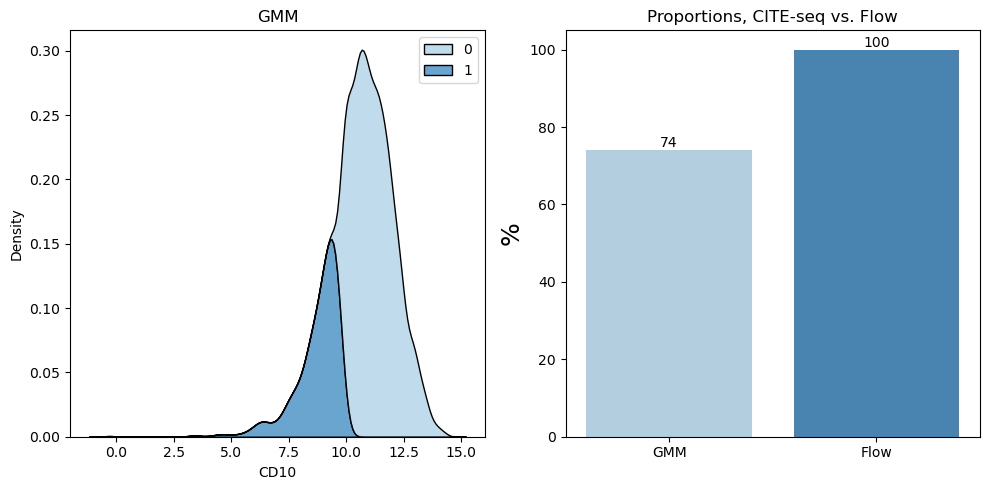

Silhuette score: 0.4503328
Percentage of positive cells: 80.54871614491734


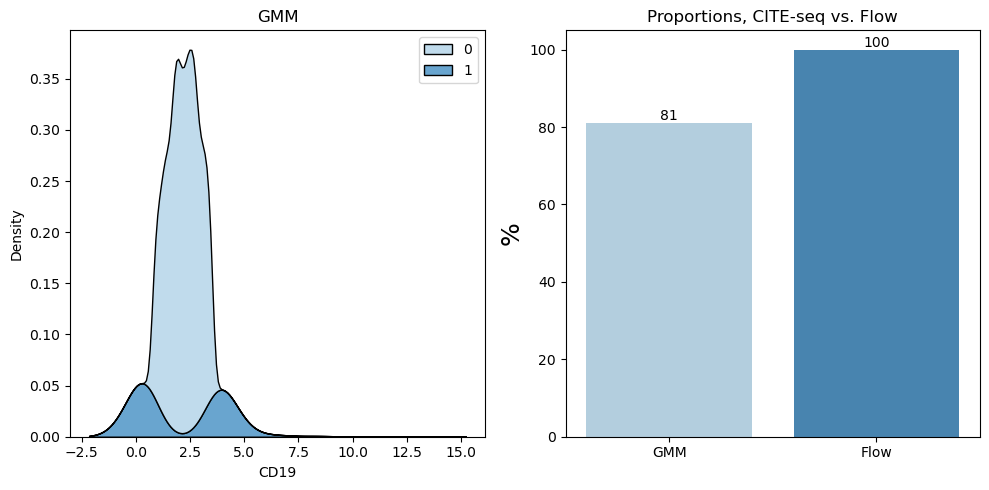

Silhuette score: 0.552312
Percentage of positive cells: 52.55012310939149


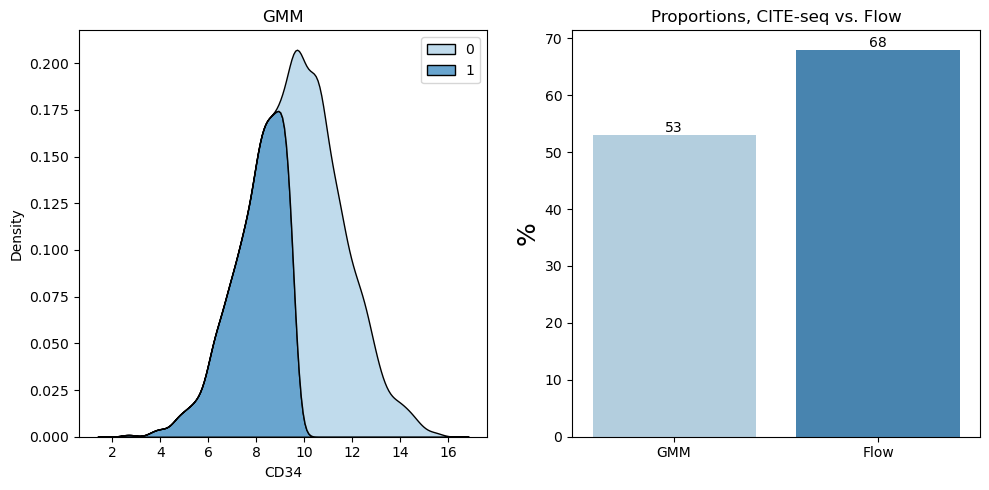

Silhuette score: 0.57187647
Percentage of positive cells: 34.82237073513893


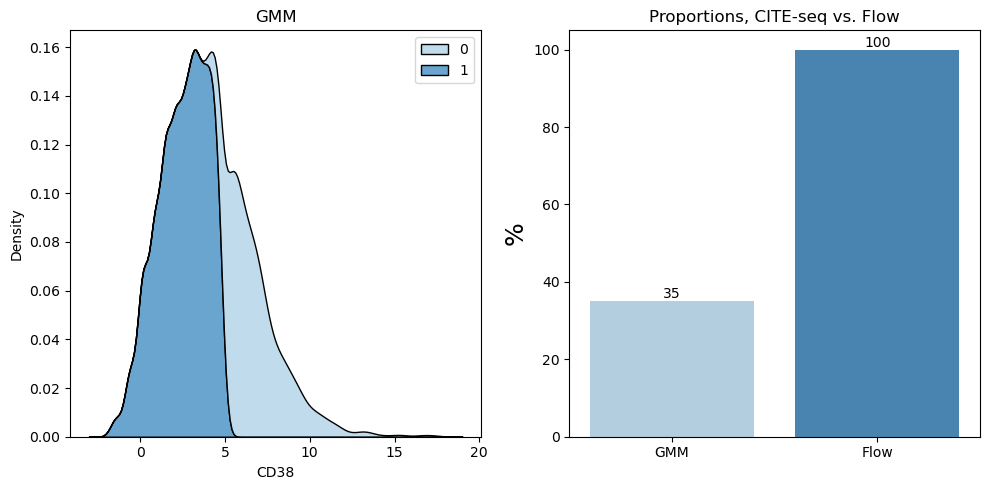

Silhuette score: 0.51775926
Percentage of positive cells: 37.10868800562786


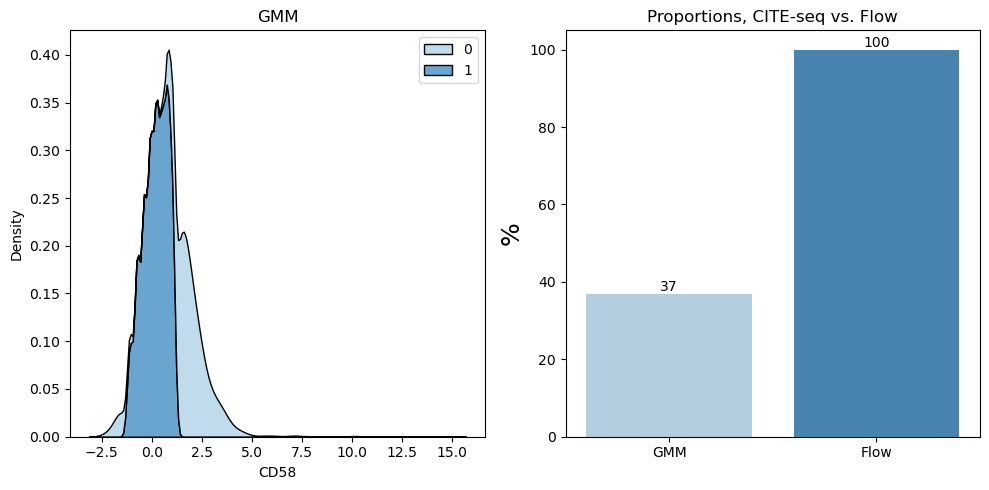

In [27]:
#model
gmm = sklearn.mixture.GaussianMixture(n_components = 2,
                                      covariance_type = "full",
                                      random_state = 42
                                        )
#data

data_dsb=prot_dsb
n_cells=len(prot_dsb)
egflow=egflow 
silhuette_scores_dsb_full = []


for column_name in column_names:
    fig, ax =plt.subplots(1,2,tight_layout=True, figsize=(10, 5))
    fig.show()
    
    x2= data_dsb[column_name]
    x2=x2.values.reshape(-1, 1)
    gmm.fit(x2)
    labels2 = gmm.predict(x2)
    score = silhouette_score(x2, labels2)
    print("Silhuette score:", score)
    silhuette_scores_dsb_full.append(score)
    
    x0 = data[column_name].reset_index(drop=True)[labels2 == 0].mean()
    x1 = data[column_name].reset_index(drop=True)[labels2 == 1].mean()
    if x0 < x1:
        labels2 = (~(labels2 == 1)).astype(int)
    
    ax1 = sns.kdeplot(data=data_dsb, x=column_name, hue=labels2, palette="Blues", multiple="stack", ax=ax[0]) ;
    ax1.title.set_text('GMM')
       
    #Calculate zeros
    n_zeros = np.count_nonzero(labels2==0)
    result_zeros2=(n_zeros/n_cells * 100)
    #Calculate ones
    n_ones=np.count_nonzero(labels2)
    result_ones2=(n_ones/n_cells * 100)
    #Dataframes
    all_data2 = {"GMM":[round(result_zeros2)],
        "Flow": egflow[column_name],
        };

    all_data2= pd.DataFrame(data=all_data2);
    
    ax2=sns.barplot(data = all_data2, palette = "Blues", ax=ax[1]);
    ax2.title.set_text('Proportions, CITE-seq vs. Flow')
    for container in ax2.containers:
        ax2.bar_label(container)
    plt.ylabel("%", fontsize=18);
    
    print("Percentage of positive cells:", result_zeros2)
    
    plt.show()
    

Silhuette score: 0.5492942
Percentage of positive cells: 74.2525501231094


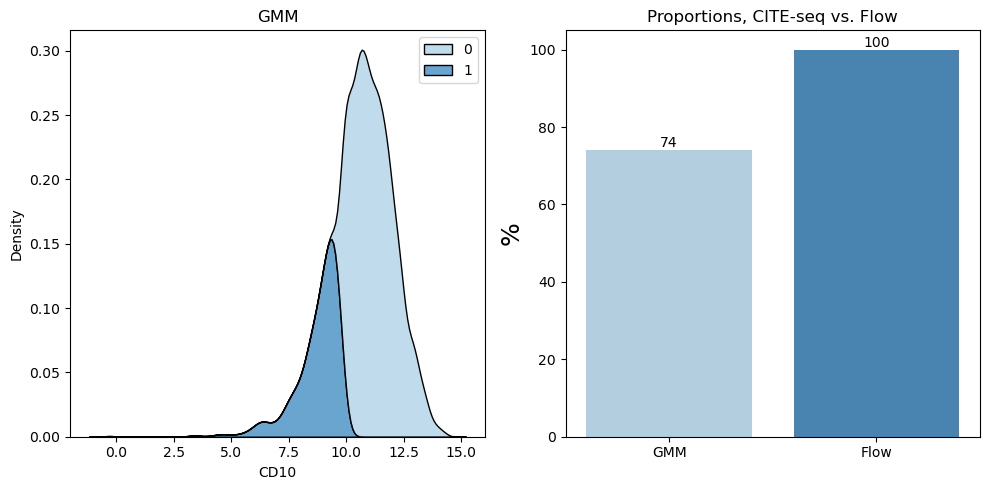

Silhuette score: 0.4503328
Percentage of positive cells: 80.54871614491734


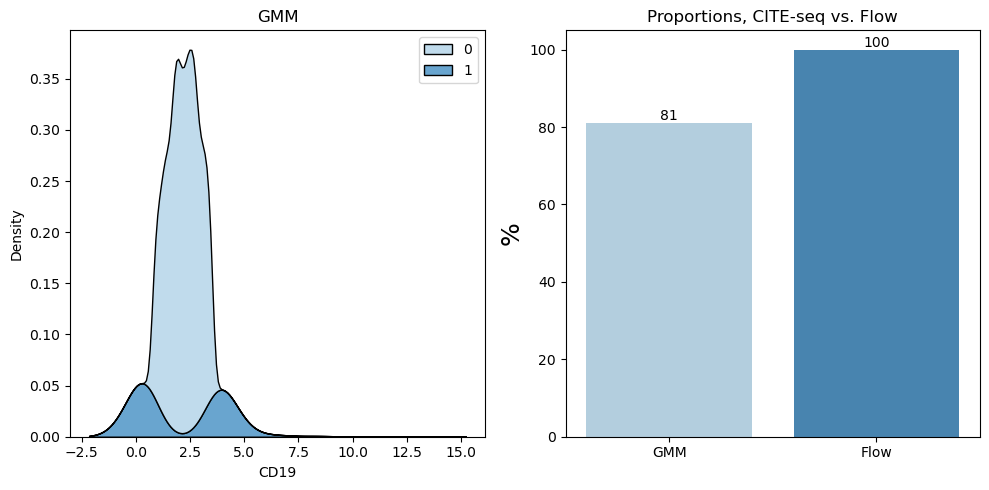

Silhuette score: 0.552312
Percentage of positive cells: 52.55012310939149


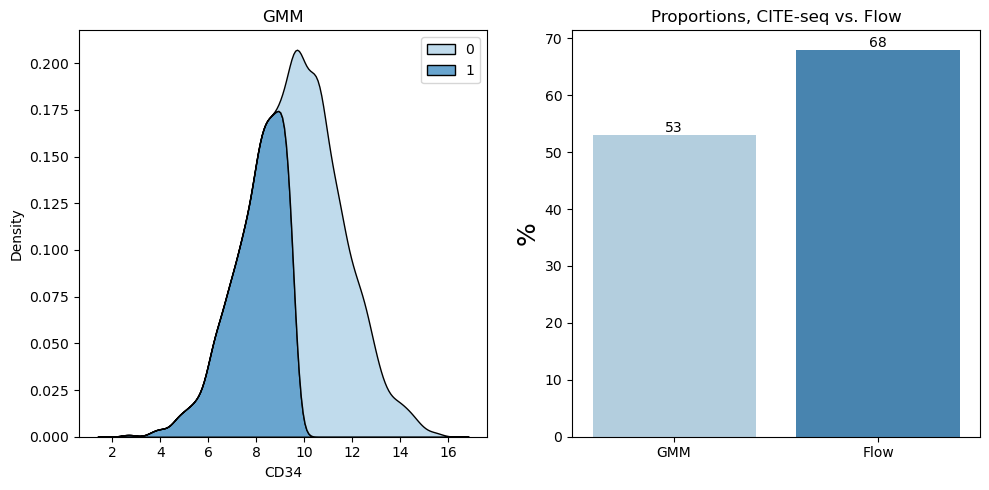

Silhuette score: 0.57187647
Percentage of positive cells: 34.82237073513893


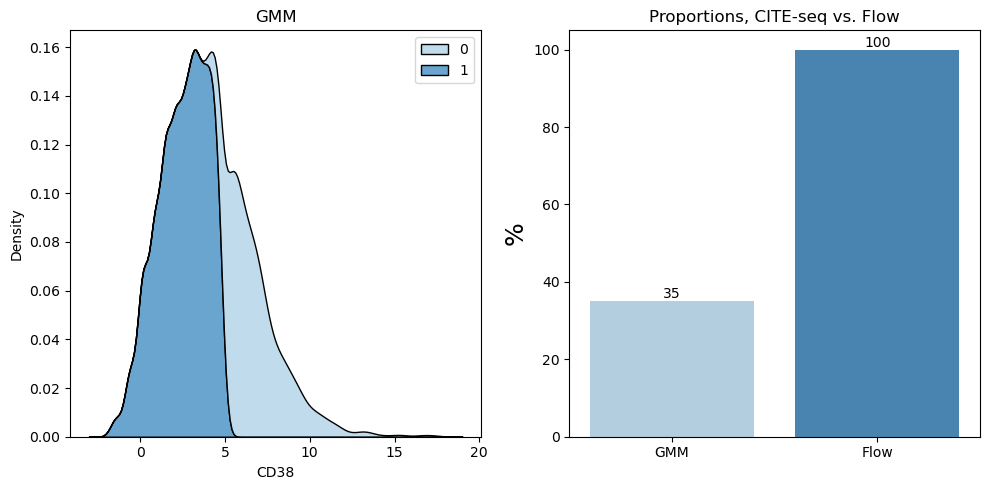

Silhuette score: 0.51775926
Percentage of positive cells: 37.10868800562786


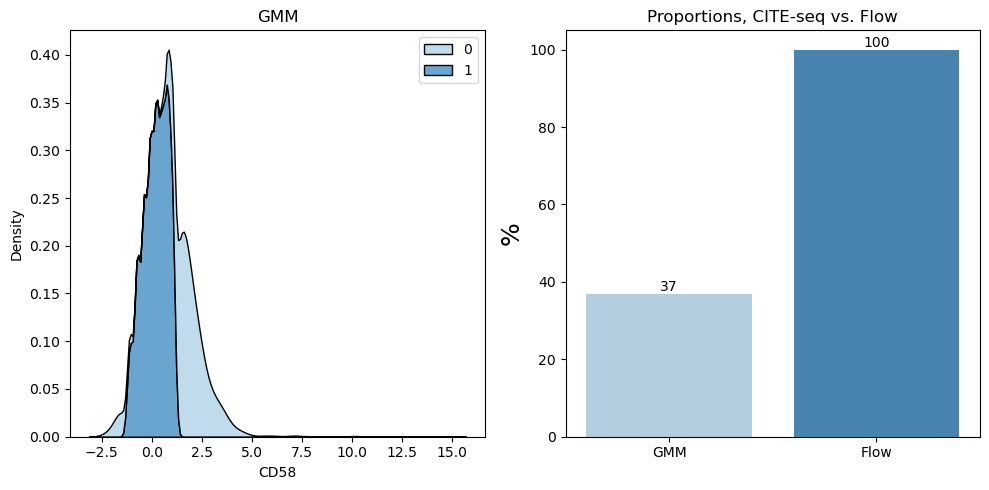

In [28]:
#model
gmm = sklearn.mixture.GaussianMixture(n_components = 2,
                                      covariance_type = "spherical",
                                      random_state = 42
                                        )
#data

data_dsb=prot_dsb
n_cells=len(prot_dsb)
egflow=egflow 
silhuette_scores_dsb_spher = []


for column_name in column_names:
    fig, ax =plt.subplots(1,2,tight_layout=True, figsize=(10, 5))
    fig.show()
    
    x2= data_dsb[column_name]
    x2=x2.values.reshape(-1, 1)
    gmm.fit(x2)
    labels2 = gmm.predict(x2)
    score = silhouette_score(x2, labels2)
    print("Silhuette score:", score)
    silhuette_scores_dsb_spher.append(score)
    
    x0 = data[column_name].reset_index(drop=True)[labels2 == 0].mean()
    x1 = data[column_name].reset_index(drop=True)[labels2 == 1].mean()
    if x0 < x1:
        labels2 = (~(labels2 == 1)).astype(int)
    
    ax1 = sns.kdeplot(data=data_dsb, x=column_name, hue=labels2, palette="Blues", multiple="stack", ax=ax[0]) ;
    ax1.title.set_text('GMM')
       
    #Calculate zeros
    n_zeros = np.count_nonzero(labels2==0)
    result_zeros2=(n_zeros/n_cells * 100)
    #Calculate ones
    n_ones=np.count_nonzero(labels2)
    result_ones2=(n_ones/n_cells * 100)
    #Dataframes
    all_data2 = {"GMM":[round(result_zeros2)],
        "Flow": egflow[column_name],
        };

    all_data2= pd.DataFrame(data=all_data2);
    
    ax2=sns.barplot(data = all_data2, palette = "Blues", ax=ax[1]);
    ax2.title.set_text('Proportions, CITE-seq vs. Flow')
    for container in ax2.containers:
        ax2.bar_label(container)
    plt.ylabel("%", fontsize=18);
    
    print("Percentage of positive cells:", result_zeros2)
    
    plt.show()
    

Silhuette score: 0.53979135
Percentage of positive cells: 81.60393950052762


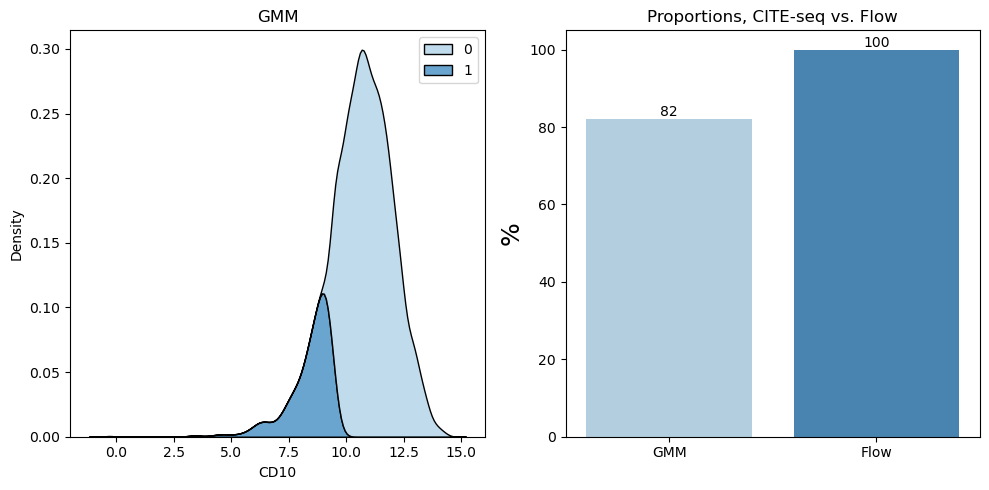

Silhuette score: 0.525083
Percentage of positive cells: 38.72669715089694


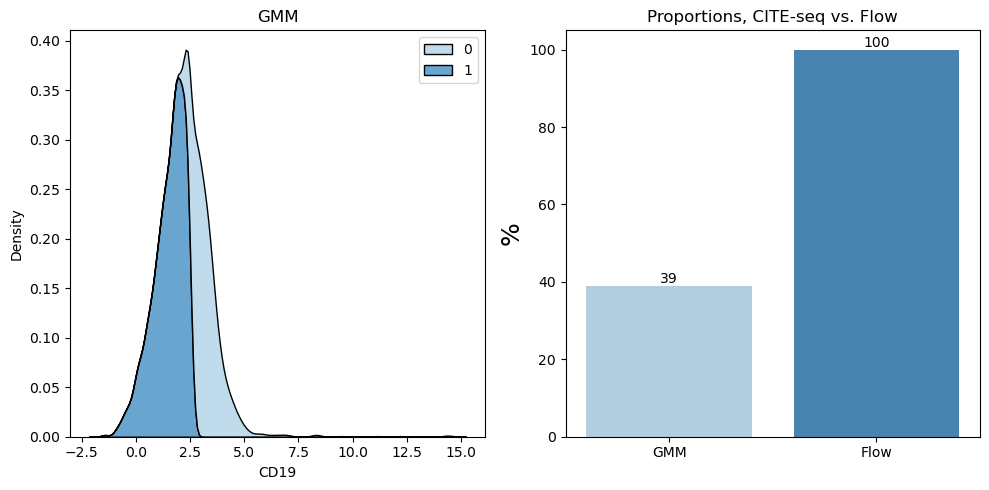

Silhuette score: 0.55291224
Percentage of positive cells: 53.57017235314808


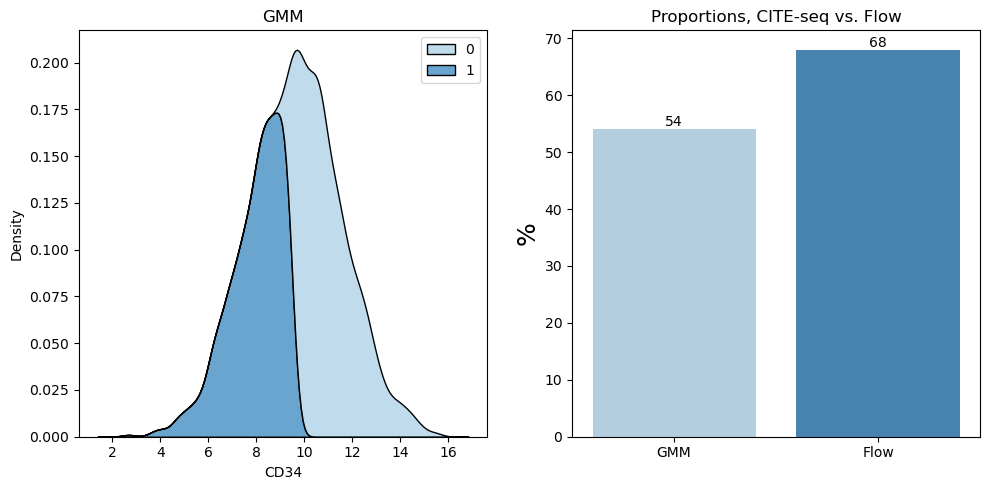

Silhuette score: 0.5477664
Percentage of positive cells: 20.682377769961306


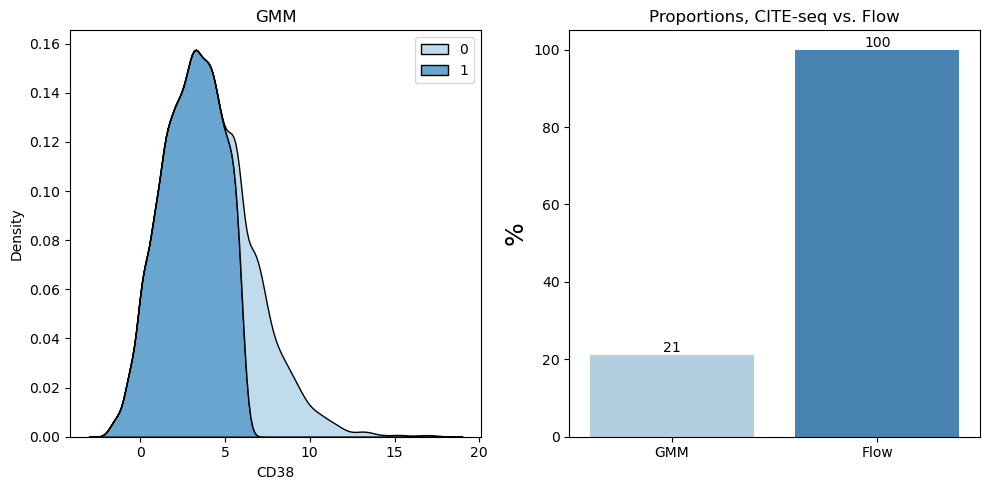

Silhuette score: 0.55363107
Percentage of positive cells: 27.646851916989096


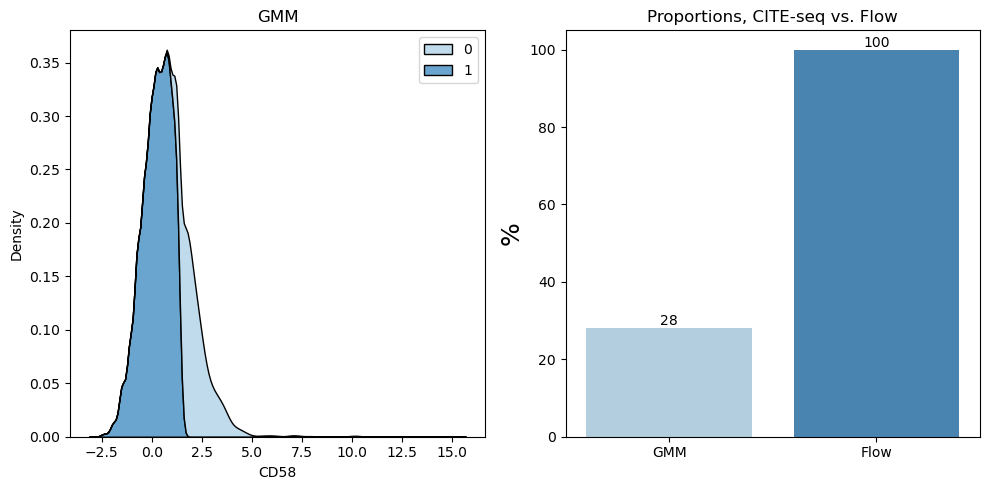

In [29]:
#model
gmm = sklearn.mixture.GaussianMixture(n_components = 2,
                                      covariance_type = "tied",
                                      random_state = 42
                                        )
#data

data_dsb=prot_dsb
n_cells=len(prot_dsb)
egflow=egflow 
silhuette_scores_dsb_tied = []


for column_name in column_names:
    fig, ax =plt.subplots(1,2,tight_layout=True, figsize=(10, 5))
    fig.show()
    
    x2= data_dsb[column_name]
    x2=x2.values.reshape(-1, 1)
    gmm.fit(x2)
    labels2 = gmm.predict(x2)
    score = silhouette_score(x2, labels2)
    print("Silhuette score:", score)
    silhuette_scores_dsb_tied.append(score)
    
    x0 = data[column_name].reset_index(drop=True)[labels2 == 0].mean()
    x1 = data[column_name].reset_index(drop=True)[labels2 == 1].mean()
    if x0 < x1:
        labels2 = (~(labels2 == 1)).astype(int)
    
    ax1 = sns.kdeplot(data=data_dsb, x=column_name, hue=labels2, palette="Blues", multiple="stack", ax=ax[0]) ;
    ax1.title.set_text('GMM')
       
    #Calculate zeros
    n_zeros = np.count_nonzero(labels2==0)
    result_zeros2=(n_zeros/n_cells * 100)
    #Calculate ones
    n_ones=np.count_nonzero(labels2)
    result_ones2=(n_ones/n_cells * 100)
    #Dataframes
    all_data2 = {"GMM":[round(result_zeros2)],
        "Flow": egflow[column_name],
        };

    all_data2= pd.DataFrame(data=all_data2);
    
    ax2=sns.barplot(data = all_data2, palette = "Blues", ax=ax[1]);
    ax2.title.set_text('Proportions, CITE-seq vs. Flow')
    for container in ax2.containers:
        ax2.bar_label(container)
    plt.ylabel("%", fontsize=18);
    
    print("Percentage of positive cells:", result_zeros2)
    
    plt.show()
    

Silhuette score: 0.5492942
Percentage of positive cells: 74.2525501231094


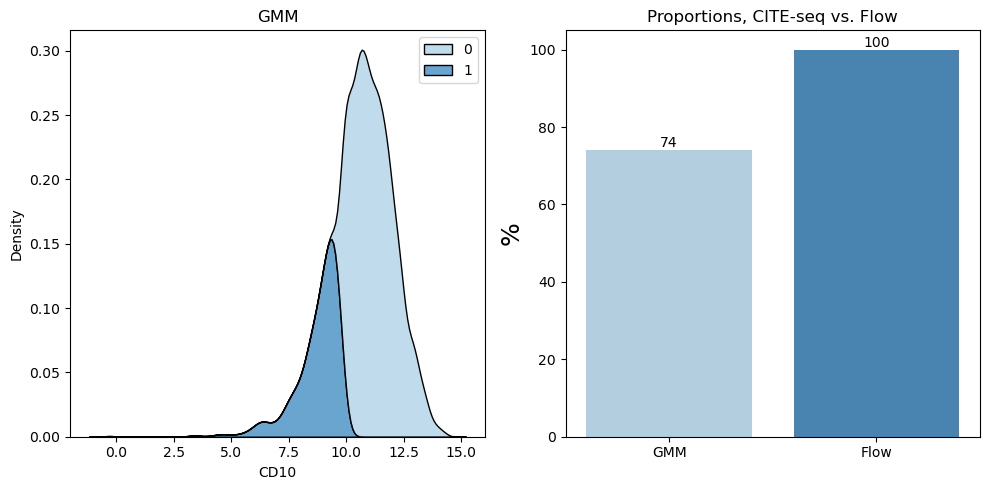

Silhuette score: 0.4503328
Percentage of positive cells: 80.54871614491734


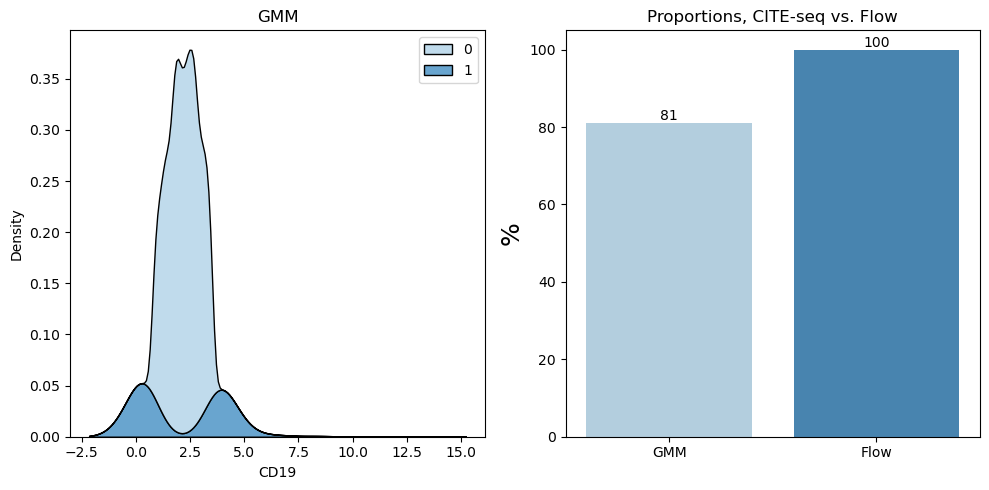

Silhuette score: 0.552312
Percentage of positive cells: 52.55012310939149


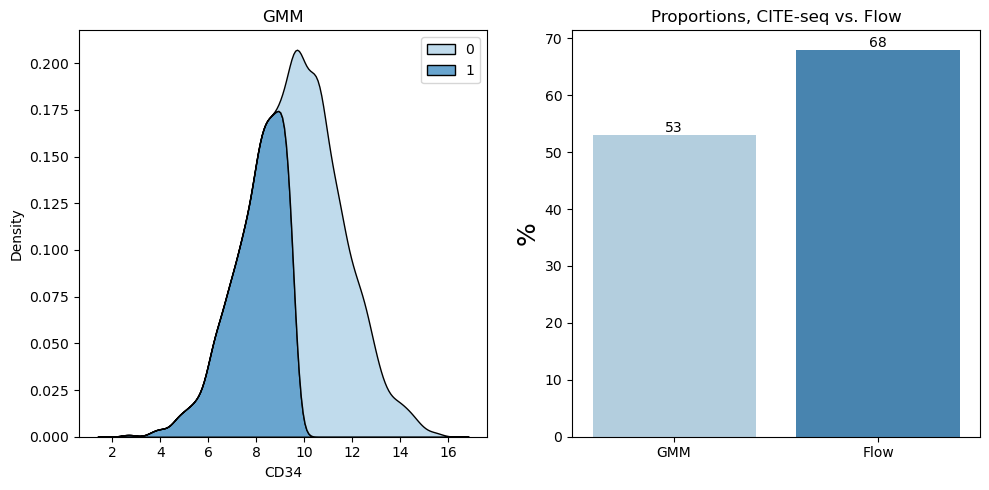

Silhuette score: 0.57187647
Percentage of positive cells: 34.82237073513893


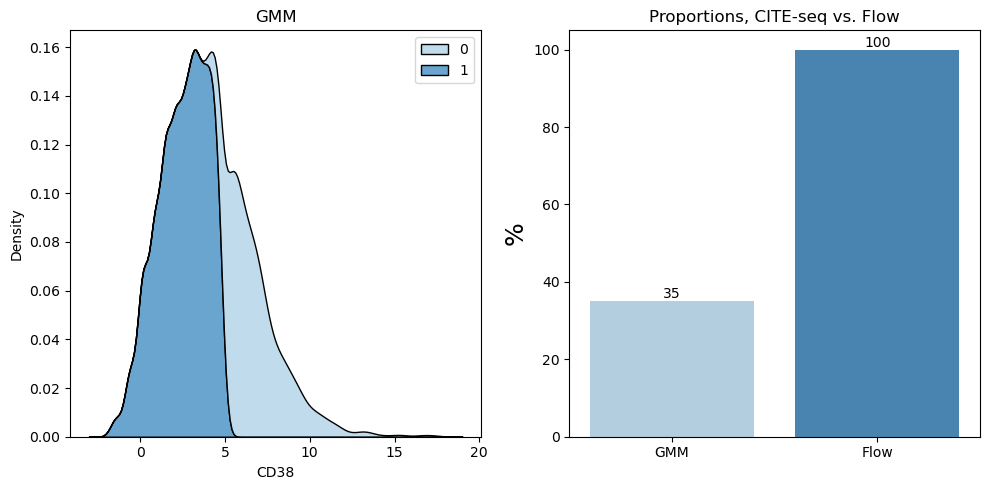

Silhuette score: 0.51775926
Percentage of positive cells: 37.10868800562786


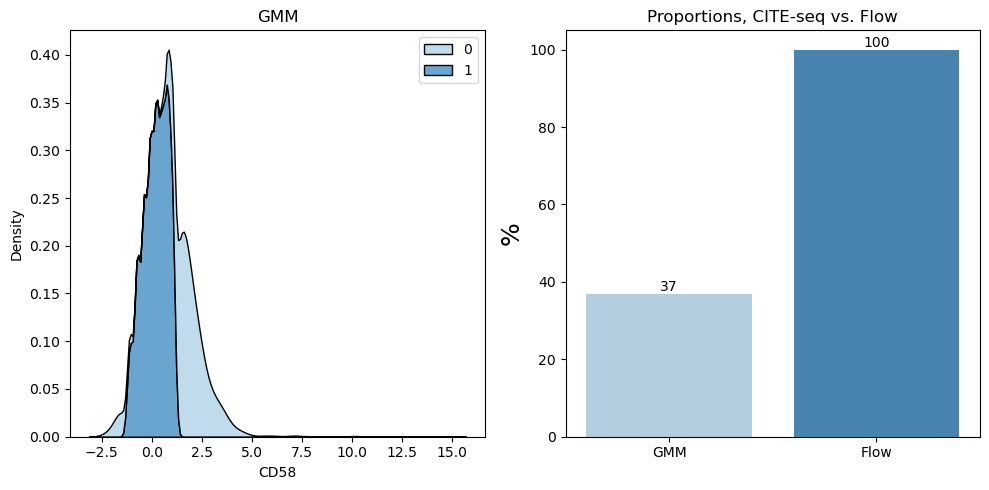

In [30]:
#model
gmm = sklearn.mixture.GaussianMixture(n_components = 2,
                                      covariance_type = "diag",
                                      random_state = 42
                                        )
#data

data_dsb=prot_dsb
n_cells=len(prot_dsb)
egflow=egflow 
silhuette_scores_dsb_diag = []


for column_name in column_names:
    fig, ax =plt.subplots(1,2,tight_layout=True, figsize=(10, 5))
    fig.show()
    
    x2= data_dsb[column_name]
    x2=x2.values.reshape(-1, 1)
    gmm.fit(x2)
    labels2 = gmm.predict(x2)
    score = silhouette_score(x2, labels2)
    print("Silhuette score:", score)
    silhuette_scores_dsb_diag.append(score)
    
    x0 = data[column_name].reset_index(drop=True)[labels2 == 0].mean()
    x1 = data[column_name].reset_index(drop=True)[labels2 == 1].mean()
    if x0 < x1:
        labels2 = (~(labels2 == 1)).astype(int)
    
    ax1 = sns.kdeplot(data=data_dsb, x=column_name, hue=labels2, palette="Blues", multiple="stack", ax=ax[0]) ;
    ax1.title.set_text('GMM')
       
    #Calculate zeros
    n_zeros = np.count_nonzero(labels2==0)
    result_zeros2=(n_zeros/n_cells * 100)
    #Calculate ones
    n_ones=np.count_nonzero(labels2)
    result_ones2=(n_ones/n_cells * 100)
    #Dataframes
    all_data2 = {"GMM":[round(result_zeros2)],
        "Flow": egflow[column_name],
        };

    all_data2= pd.DataFrame(data=all_data2);
    
    ax2=sns.barplot(data = all_data2, palette = "Blues", ax=ax[1]);
    ax2.title.set_text('Proportions, CITE-seq vs. Flow')
    for container in ax2.containers:
        ax2.bar_label(container)
    plt.ylabel("%", fontsize=18);
    
    print("Percentage of positive cells:", result_zeros2)
    
    plt.show()
    

## Silhuette scores

In [31]:
silhuettes = {"silhuette_scores_dsb_diag":[silhuette_scores_dsb_diag[0]],
              "silhuette_scores_dsb_spher": [silhuette_scores_dsb_spher[0]],
            "silhuette_scores_dsb_tied": [silhuette_scores_dsb_tied[0]],
              "silhuette_scores_dsb_full": [silhuette_scores_dsb_full[0]],
              "silhuette_scores_clr_diag":[silhuette_scores_clr_diag[0]],
              "silhuette_scores_clr_spher": [silhuette_scores_clr_spher[0]],
            "silhuette_scores_clr_tied": [silhuette_scores_clr_tied[0]],
              "silhuette_scores_clr_full": [silhuette_scores_clr_full[0]]
      };

silhuette_df= pd.DataFrame(data=silhuettes)

silhuette_df.T

,0
silhuette_scores_dsb_diag,0.549294
silhuette_scores_dsb_spher,0.549294
silhuette_scores_dsb_tied,0.539791
silhuette_scores_dsb_full,0.549294
silhuette_scores_clr_diag,0.555124
silhuette_scores_clr_spher,0.555124
silhuette_scores_clr_tied,0.539395
silhuette_scores_clr_full,0.555124


In [32]:
silhuettes = {"silhuette_scores_dsb_diag":[silhuette_scores_dsb_diag[1]],
              "silhuette_scores_dsb_spher": [silhuette_scores_dsb_spher[1]],
            "silhuette_scores_dsb_tied": [silhuette_scores_dsb_tied[1]],
              "silhuette_scores_dsb_full": [silhuette_scores_dsb_full[1]],
              "silhuette_scores_clr_diag":[silhuette_scores_clr_diag[1]],
              "silhuette_scores_clr_spher": [silhuette_scores_clr_spher[1]],
            "silhuette_scores_clr_tied": [silhuette_scores_clr_tied[1]],
              "silhuette_scores_clr_full": [silhuette_scores_clr_full[1]]
      };

silhuette_df1= pd.DataFrame(data=silhuettes)

silhuette_df1.T

,0
silhuette_scores_dsb_diag,0.450333
silhuette_scores_dsb_spher,0.450333
silhuette_scores_dsb_tied,0.525083
silhuette_scores_dsb_full,0.450333
silhuette_scores_clr_diag,0.809219
silhuette_scores_clr_spher,0.809219
silhuette_scores_clr_tied,0.500467
silhuette_scores_clr_full,0.809219


In [33]:
silhuettes = {"silhuette_scores_dsb_diag":[silhuette_scores_dsb_diag[2]],
              "silhuette_scores_dsb_spher": [silhuette_scores_dsb_spher[2]],
            "silhuette_scores_dsb_tied": [silhuette_scores_dsb_tied[2]],
              "silhuette_scores_dsb_full": [silhuette_scores_dsb_full[2]],
              "silhuette_scores_clr_diag":[silhuette_scores_clr_diag[2]],
              "silhuette_scores_clr_spher": [silhuette_scores_clr_spher[2]],
            "silhuette_scores_clr_tied": [silhuette_scores_clr_tied[2]],
              "silhuette_scores_clr_full": [silhuette_scores_clr_full[2]]
      };

silhuette_df2= pd.DataFrame(data=silhuettes)

silhuette_df2.T

,0
silhuette_scores_dsb_diag,0.552312
silhuette_scores_dsb_spher,0.552312
silhuette_scores_dsb_tied,0.552912
silhuette_scores_dsb_full,0.552312
silhuette_scores_clr_diag,0.554529
silhuette_scores_clr_spher,0.554529
silhuette_scores_clr_tied,0.553171
silhuette_scores_clr_full,0.554529


In [34]:
silhuettes = {"silhuette_scores_dsb_diag":[silhuette_scores_dsb_diag[3]],
              "silhuette_scores_dsb_spher": [silhuette_scores_dsb_spher[3]],
            "silhuette_scores_dsb_tied": [silhuette_scores_dsb_tied[3]],
              "silhuette_scores_dsb_full": [silhuette_scores_dsb_full[3]],
              "silhuette_scores_clr_diag":[silhuette_scores_clr_diag[3]],
              "silhuette_scores_clr_spher": [silhuette_scores_clr_spher[3]],
            "silhuette_scores_clr_tied": [silhuette_scores_clr_tied[3]],
              "silhuette_scores_clr_full": [silhuette_scores_clr_full[3]]
      };

silhuette_df3= pd.DataFrame(data=silhuettes)

silhuette_df3.T

,0
silhuette_scores_dsb_diag,0.571876
silhuette_scores_dsb_spher,0.571876
silhuette_scores_dsb_tied,0.547766
silhuette_scores_dsb_full,0.571876
silhuette_scores_clr_diag,0.569996
silhuette_scores_clr_spher,0.569996
silhuette_scores_clr_tied,0.555971
silhuette_scores_clr_full,0.569996


In [35]:
silhuettes = {"silhuette_scores_dsb_diag":[silhuette_scores_dsb_diag[4]],
              "silhuette_scores_dsb_spher": [silhuette_scores_dsb_spher[4]],
            "silhuette_scores_dsb_tied": [silhuette_scores_dsb_tied[4]],
              "silhuette_scores_dsb_full": [silhuette_scores_dsb_full[4]],
              "silhuette_scores_clr_diag":[silhuette_scores_clr_diag[4]],
              "silhuette_scores_clr_spher": [silhuette_scores_clr_spher[4]],
            "silhuette_scores_clr_tied": [silhuette_scores_clr_tied[4]],
              "silhuette_scores_clr_full": [silhuette_scores_clr_full[4]]
      };

silhuette_df4= pd.DataFrame(data=silhuettes)

silhuette_df4.T

,0
silhuette_scores_dsb_diag,0.517759
silhuette_scores_dsb_spher,0.517759
silhuette_scores_dsb_tied,0.553631
silhuette_scores_dsb_full,0.517759
silhuette_scores_clr_diag,0.535386
silhuette_scores_clr_spher,0.535386
silhuette_scores_clr_tied,0.541763
silhuette_scores_clr_full,0.535386


In [36]:
column_names


['CD10', 'CD19', 'CD34', 'CD38', 'CD58']

In [38]:
the_df= pd.concat([silhuette_df,silhuette_df1,silhuette_df2,silhuette_df3,silhuette_df4], axis=0)


In [39]:
the_df = the_df.T

the_df

,0,0,0,0,0
silhuette_scores_dsb_diag,0.549294,0.450333,0.552312,0.571876,0.517759
silhuette_scores_dsb_spher,0.549294,0.450333,0.552312,0.571876,0.517759
silhuette_scores_dsb_tied,0.539791,0.525083,0.552912,0.547766,0.553631
silhuette_scores_dsb_full,0.549294,0.450333,0.552312,0.571876,0.517759
silhuette_scores_clr_diag,0.555124,0.809219,0.554529,0.569996,0.535386
silhuette_scores_clr_spher,0.555124,0.809219,0.554529,0.569996,0.535386
silhuette_scores_clr_tied,0.539395,0.500467,0.553171,0.555971,0.541763
silhuette_scores_clr_full,0.555124,0.809219,0.554529,0.569996,0.535386


In [40]:
the_df.columns = column_names

In [43]:
the_df= the_df.T


In [42]:
the_df

,silhuette_scores_dsb_diag,silhuette_scores_dsb_spher,silhuette_scores_dsb_tied,silhuette_scores_dsb_full,silhuette_scores_clr_diag,silhuette_scores_clr_spher,silhuette_scores_clr_tied,silhuette_scores_clr_full
CD10,0.549294,0.549294,0.539791,0.549294,0.555124,0.555124,0.539395,0.555124
CD19,0.450333,0.450333,0.525083,0.450333,0.809219,0.809219,0.500467,0.809219
CD34,0.552312,0.552312,0.552912,0.552312,0.554529,0.554529,0.553171,0.554529
CD38,0.571876,0.571876,0.547766,0.571876,0.569996,0.569996,0.555971,0.569996
CD58,0.517759,0.517759,0.553631,0.517759,0.535386,0.535386,0.541763,0.535386


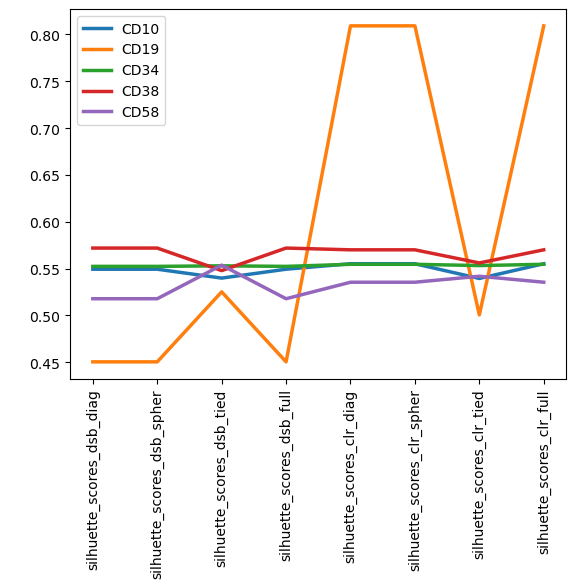

In [44]:
a = sns.lineplot(data=the_df["CD10"], palette=['red'], linewidth=2.5, label='CD10')
a = sns.lineplot(data=the_df["CD19"], palette=['green'], linewidth=2.5, label='CD19')
a = sns.lineplot(data=the_df["CD34"],palette=['black'],linewidth=2.5, label='CD34')
a = sns.lineplot(data=the_df["CD38"],palette=['blue'],linewidth=2.5, label='CD38')
a = sns.lineplot(data=the_df["CD58"],palette=['violet'],linewidth=2.5, label='CD58')

a.set_xticklabels(a.get_xticklabels(),rotation=90) ;
plt.ylabel(" ");

